In [1]:
#!/usr/bin/env python
# coding: utf-8

import gym
import torch
import copy
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import random
import statistics
import time 

from torch import nn
from tqdm import tqdm
from scipy.optimize import minimize_scalar

In [2]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)  
        self.fc2 = nn.Linear(64, output_dim) 

        # Apply the weights initialization
        self.apply(self.init_weights)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def init_weights(self, m):
        if type(m) == nn.Linear:
            init.xavier_normal_(m.weight)
            # init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def inject_parameters(self, pvec):
        new_state_dict = {}
        count = 0
        for name, param in self.named_parameters():
            sz = param.data.numel()
            raw = pvec[count:count + sz]
            reshaped = raw.reshape(param.data.shape)
            new_state_dict[name] = torch.from_numpy(reshaped).float()
            count += sz
        self.load_state_dict(new_state_dict)

In [3]:
def calculate_fitness(network, env, num_episodes):
    total_rewards = 0
    for _ in range(num_episodes):
        reward, _ = run_episode(network, env)
        total_rewards += reward
    avg_reward = total_rewards / num_episodes
    return avg_reward

def run_episode(network, env):
    state = env.reset()
    total_reward = 0.0
    done = False
    while not done:
        action = torch.argmax(network(torch.from_numpy(state).float().unsqueeze(0))).item()
        state, reward, done, _ = env.step(action)
        total_reward += reward
    return total_reward, _

def select_survivors(population, fitnesses, ELITISM):
    sorted_population = [x for _, x in sorted(zip(fitnesses, population), key=lambda pair: pair[0], reverse=True)]
    return sorted_population[:ELITISM]

def tournament_selection(population, fitnesses, tournament_size):
    selected_indices = np.random.randint(len(population), size=tournament_size)
    selected_fitnesses = [fitnesses[i] for i in selected_indices]
    winner_index = selected_indices[np.argmax(selected_fitnesses)]
    return population[winner_index]

def perturb_parameters(network, weight_clip, n_episodes):

    for episode in range(n_episodes):
        # Reset the environment
        state = env.reset()
        done = False
        total_reward = 0
        current_output = None

        while not done:

            if episode == 0 and current_output is None:
                prev_output = torch.Tensor([0.5, 0.5])
            else:
                prev_output = current_output.detach()

            # Get the original parameters
            current_param = torch.cat([param.view(-1) for param in network.parameters()])

            # Perturb the model parameters
            delta = torch.randn_like(current_param)

            # Forward pass to calculate the output
            current_output = network(torch.from_numpy(state).float().unsqueeze(0))

            # Calculate the error
            error = ((current_output - prev_output)**2).mean()

            # Clear the gradients from the last backward pass
            network.zero_grad()

            # Backward pass to calculate the gradients
            error.backward()

            # Extract the gradients
            gradient = torch.cat([param.grad.view(-1) for param in network.parameters()])

            # Normalize the gradients
            gradient /= ((gradient**2).sum() + 1e-10)

            # Calculate the new parameters
            perturbation = np.clip(delta * gradient, -weight_clip, weight_clip)
            new_param = current_param + perturbation

            # Inject the new parameters into the model
            network.inject_parameters(new_param.detach().numpy())

            action = torch.argmax(network(torch.from_numpy(state).float().unsqueeze(0))).item()
            state, reward, done, _ = env.step(action)

In [4]:
# Constants
POPULATION_SIZE = 50
GENERATIONS = 1000
ELITISM = int(POPULATION_SIZE * 0.4)
TOURNAMENT_SIZE = 5
WEIGHT_CLIP = 0.2
INPUT_DIM = 4  # For CartPole environment
OUTPUT_DIM = 2  # For CartPole environment
MAX_EP = 1

FITNESS_HISTORY = list()
FITNESS_STDERROR_HISTORY = list()

env = gym.make("CartPole-v1")

# Creating initial population of networks
population = [PolicyNetwork(INPUT_DIM, OUTPUT_DIM) for _ in range(POPULATION_SIZE)]

/Users/jinhyunpark/miniforge3/envs/tilda/lib/python3.11/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/jinhyunpark/miniforge3/envs/tilda/lib/python3.11/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [5]:
start_time = time.time()

In [6]:
# Generations loop
for generation in range(GENERATIONS):
    print(f"[Generation {generation}]")
    
    # Calculate fitness for each network
    print("Calculating Fitnesses For Population ...")
    fitnesses = [calculate_fitness(network, env, MAX_EP) for network in tqdm(population)]
    
    avg_fitness = np.average(fitnesses)
    max_fitness = np.max(fitnesses)
    min_fitness = np.min(fitnesses)
    FITNESS_HISTORY.append([avg_fitness, max_fitness, min_fitness])
    
    # std error
    standard_deviation = statistics.stdev(fitnesses)
    standard_error = standard_deviation / (POPULATION_SIZE ** 0.5)
    FITNESS_STDERROR_HISTORY.append(standard_error)
    
    print(f"Average Fitness: {avg_fitness} \n Best Fitness: {max_fitness} \n Worst Fitness: {min_fitness} \n Standard Error: {standard_error}")

    # Select the best networks to pass their genes to the next generation
    survivors = select_survivors(population, fitnesses, ELITISM)

    # Create the next generation
    next_population = survivors  # Start with the survivors
    
    print("Generating Offsprings ...")
    # Add offspring by tournament selection and mutation
    for _ in tqdm(range(POPULATION_SIZE - len(survivors))):
        parent = tournament_selection(population, fitnesses, TOURNAMENT_SIZE)
        offspring = copy.deepcopy(parent)

        # Perturb the offspring using your approach
        perturb_parameters(offspring, WEIGHT_CLIP, MAX_EP)

        next_population.append(offspring)

    # The next generation becomes the current population
    population = next_population

[Generation 0]
Calculating Fitnesses For Population ...


  0%|                                                                                                                                                           | 0/50 [00:00<?, ?it/s]/Users/jinhyunpark/miniforge3/envs/tilda/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1082.02it/s]


Average Fitness: 41.88 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 13.121679832729232
Generating Offsprings ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 265.29it/s]


[Generation 1]
Calculating Fitnesses For Population ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1505.54it/s]


Average Fitness: 30.26 
 Best Fitness: 254.0 
 Worst Fitness: 8.0 
 Standard Error: 7.082131006401726
Generating Offsprings ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 291.38it/s]


[Generation 2]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 838.31it/s]


Average Fitness: 35.3 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 10.458011283222065
Generating Offsprings ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 336.58it/s]


[Generation 3]
Calculating Fitnesses For Population ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1339.52it/s]


Average Fitness: 37.1 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 11.46808348310694
Generating Offsprings ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 269.39it/s]


[Generation 4]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 891.85it/s]


Average Fitness: 56.88 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 15.079155500632151
Generating Offsprings ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 279.34it/s]


[Generation 5]
Calculating Fitnesses For Population ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1303.54it/s]


Average Fitness: 40.12 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 10.597405920549516
Generating Offsprings ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 321.59it/s]


[Generation 6]
Calculating Fitnesses For Population ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1074.88it/s]


Average Fitness: 48.1 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 12.639596028160948
Generating Offsprings ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 305.28it/s]


[Generation 7]
Calculating Fitnesses For Population ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1319.58it/s]


Average Fitness: 38.04 
 Best Fitness: 383.0 
 Worst Fitness: 8.0 
 Standard Error: 8.320074567954697
Generating Offsprings ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 219.92it/s]


[Generation 8]
Calculating Fitnesses For Population ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1129.25it/s]


Average Fitness: 46.02 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 11.666784877923956
Generating Offsprings ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 296.30it/s]


[Generation 9]
Calculating Fitnesses For Population ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1279.37it/s]


Average Fitness: 39.66 
 Best Fitness: 270.0 
 Worst Fitness: 8.0 
 Standard Error: 7.211023873634204
Generating Offsprings ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 262.04it/s]


[Generation 10]
Calculating Fitnesses For Population ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1155.05it/s]


Average Fitness: 44.82 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 10.56334401289165
Generating Offsprings ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 250.28it/s]


[Generation 11]
Calculating Fitnesses For Population ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1175.89it/s]


Average Fitness: 44.38 
 Best Fitness: 267.0 
 Worst Fitness: 8.0 
 Standard Error: 7.801459308804909
Generating Offsprings ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 250.02it/s]


[Generation 12]
Calculating Fitnesses For Population ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1112.79it/s]


Average Fitness: 47.06 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 10.681145318088431
Generating Offsprings ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 239.60it/s]


[Generation 13]
Calculating Fitnesses For Population ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1097.77it/s]


Average Fitness: 47.44 
 Best Fitness: 334.0 
 Worst Fitness: 8.0 
 Standard Error: 8.311789512370918
Generating Offsprings ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 163.07it/s]


[Generation 14]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 871.88it/s]


Average Fitness: 60.28 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 11.745048109822317
Generating Offsprings ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 159.50it/s]


[Generation 15]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 681.46it/s]


Average Fitness: 76.52 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 16.25067006467796
Generating Offsprings ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 216.94it/s]


[Generation 16]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 769.26it/s]


Average Fitness: 69.94 
 Best Fitness: 483.0 
 Worst Fitness: 8.0 
 Standard Error: 12.607882535969962
Generating Offsprings ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 134.77it/s]


[Generation 17]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 764.71it/s]


Average Fitness: 69.0 
 Best Fitness: 480.0 
 Worst Fitness: 8.0 
 Standard Error: 13.79798861413932
Generating Offsprings ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 192.11it/s]


[Generation 18]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 764.78it/s]


Average Fitness: 68.14 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 13.207110329868003
Generating Offsprings ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 129.55it/s]


[Generation 19]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 852.50it/s]


Average Fitness: 61.2 
 Best Fitness: 411.0 
 Worst Fitness: 8.0 
 Standard Error: 9.99995918359017
Generating Offsprings ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 163.79it/s]


[Generation 20]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 646.40it/s]


Average Fitness: 82.84 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 13.02936589056444
Generating Offsprings ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 112.52it/s]


[Generation 21]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 641.70it/s]


Average Fitness: 82.9 
 Best Fitness: 339.0 
 Worst Fitness: 8.0 
 Standard Error: 11.528465214593034
Generating Offsprings ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 109.31it/s]


[Generation 22]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 602.57it/s]


Average Fitness: 87.72 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 12.390649535773633
Generating Offsprings ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 101.04it/s]


[Generation 23]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 547.97it/s]


Average Fitness: 97.52 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 14.436468560205293
Generating Offsprings ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 107.96it/s]


[Generation 24]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 505.56it/s]


Average Fitness: 104.8 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 14.587694003046902
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 70.56it/s]


[Generation 25]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 411.13it/s]


Average Fitness: 129.78 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 17.955461678320408
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 72.28it/s]


[Generation 26]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 381.92it/s]


Average Fitness: 139.1 
 Best Fitness: 455.0 
 Worst Fitness: 8.0 
 Standard Error: 18.96773307380678
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 84.04it/s]


[Generation 27]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 366.21it/s]


Average Fitness: 142.1 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 20.26280900002338
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 79.10it/s]


[Generation 28]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 364.55it/s]


Average Fitness: 146.06 
 Best Fitness: 465.0 
 Worst Fitness: 8.0 
 Standard Error: 18.838831152268273
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 86.03it/s]


[Generation 29]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 396.19it/s]


Average Fitness: 136.22 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 19.812576710725118
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.59it/s]


[Generation 30]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 339.03it/s]


Average Fitness: 155.96 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 20.990201017987182
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 66.03it/s]


[Generation 31]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 317.37it/s]


Average Fitness: 166.66 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 22.085134163513885
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 72.67it/s]


[Generation 32]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 305.80it/s]


Average Fitness: 173.2 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 21.2300518614726
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 71.43it/s]


[Generation 33]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 283.37it/s]


Average Fitness: 185.66 
 Best Fitness: 478.0 
 Worst Fitness: 8.0 
 Standard Error: 21.161740794872895
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.15it/s]


[Generation 34]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 259.36it/s]


Average Fitness: 202.72 
 Best Fitness: 479.0 
 Worst Fitness: 9.0 
 Standard Error: 22.701830187840606
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.99it/s]


[Generation 35]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 268.09it/s]


Average Fitness: 199.14 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 25.28692507189905
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.06it/s]


[Generation 36]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 266.32it/s]


Average Fitness: 196.74 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 23.09612230020707
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.55it/s]


[Generation 37]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 282.35it/s]


Average Fitness: 189.82 
 Best Fitness: 492.0 
 Worst Fitness: 8.0 
 Standard Error: 21.9373447317024
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.56it/s]


[Generation 38]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 221.55it/s]


Average Fitness: 235.44 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 25.474711910810207
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.65it/s]


[Generation 39]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 204.45it/s]


Average Fitness: 257.3 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 23.620092622811708
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.03it/s]


[Generation 40]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 215.48it/s]


Average Fitness: 245.2 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 26.018972669486974
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.60it/s]


[Generation 41]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 213.29it/s]


Average Fitness: 244.64 
 Best Fitness: 500.0 
 Worst Fitness: 12.0 
 Standard Error: 24.23018458241619
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.97it/s]


[Generation 42]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 200.92it/s]


Average Fitness: 263.0 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 25.05222300617293
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.66it/s]


[Generation 43]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 198.83it/s]


Average Fitness: 265.62 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 25.024133494346156
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.46it/s]


[Generation 44]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 196.41it/s]


Average Fitness: 263.66 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 25.696749734913467
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.29it/s]


[Generation 45]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 194.40it/s]


Average Fitness: 271.98 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 21.98518035181974
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.84it/s]


[Generation 46]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 193.70it/s]


Average Fitness: 272.22 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 24.59497692204484
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.74it/s]


[Generation 47]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 199.38it/s]


Average Fitness: 264.1 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 26.131617412082026
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.95it/s]


[Generation 48]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 179.77it/s]


Average Fitness: 288.2 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 25.604320426244392
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.88it/s]


[Generation 49]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 166.21it/s]


Average Fitness: 314.86 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 23.79499192721709
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.61it/s]


[Generation 50]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 176.58it/s]


Average Fitness: 293.06 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 25.919032641308675
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.31it/s]


[Generation 51]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 174.49it/s]


Average Fitness: 296.14 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 25.312028438540228
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.71it/s]


[Generation 52]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.88it/s]


Average Fitness: 325.02 
 Best Fitness: 500.0 
 Worst Fitness: 15.0 
 Standard Error: 25.237233426435793
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 21.53it/s]


[Generation 53]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 166.68it/s]


Average Fitness: 306.72 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 22.46568430804126
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.88it/s]


[Generation 54]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 179.32it/s]


Average Fitness: 284.8 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 24.316921126269758
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.46it/s]


[Generation 55]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 166.38it/s]


Average Fitness: 301.26 
 Best Fitness: 500.0 
 Worst Fitness: 20.0 
 Standard Error: 22.787014024730514
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.56it/s]


[Generation 56]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 181.58it/s]


Average Fitness: 282.06 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 27.37438710524411
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.23it/s]


[Generation 57]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 182.45it/s]


Average Fitness: 280.58 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 27.13448126405566
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.35it/s]


[Generation 58]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 195.33it/s]


Average Fitness: 260.16 
 Best Fitness: 500.0 
 Worst Fitness: 12.0 
 Standard Error: 24.863059394390294
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.93it/s]


[Generation 59]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 166.84it/s]


Average Fitness: 304.3 
 Best Fitness: 500.0 
 Worst Fitness: 11.0 
 Standard Error: 26.01249699663606
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.50it/s]


[Generation 60]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 169.09it/s]


Average Fitness: 305.34 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 25.403319885882823
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.90it/s]


[Generation 61]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 163.64it/s]


Average Fitness: 314.54 
 Best Fitness: 500.0 
 Worst Fitness: 15.0 
 Standard Error: 25.0468982152298
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.18it/s]


[Generation 62]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 166.71it/s]


Average Fitness: 304.62 
 Best Fitness: 500.0 
 Worst Fitness: 11.0 
 Standard Error: 26.72048652251676
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.88it/s]


[Generation 63]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 174.83it/s]


Average Fitness: 293.98 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 28.124308463153582
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.48it/s]


[Generation 64]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 168.52it/s]


Average Fitness: 305.02 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 25.62617427871873
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.57it/s]


[Generation 65]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 148.74it/s]


Average Fitness: 306.5 
 Best Fitness: 500.0 
 Worst Fitness: 13.0 
 Standard Error: 24.94433394417192
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.49it/s]


[Generation 66]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 165.61it/s]


Average Fitness: 306.5 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 27.8494824632234
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.63it/s]


[Generation 67]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 156.73it/s]


Average Fitness: 317.48 
 Best Fitness: 500.0 
 Worst Fitness: 11.0 
 Standard Error: 25.04569277402029
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.45it/s]


[Generation 68]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 165.43it/s]


Average Fitness: 303.16 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 27.908309932084855
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.96it/s]


[Generation 69]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 170.86it/s]


Average Fitness: 297.46 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 25.64570553221139
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.52it/s]


[Generation 70]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 165.30it/s]


Average Fitness: 306.76 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 25.46902977247112
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.36it/s]


[Generation 71]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 159.20it/s]


Average Fitness: 315.24 
 Best Fitness: 500.0 
 Worst Fitness: 11.0 
 Standard Error: 25.90076131573537
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.51it/s]


[Generation 72]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 175.61it/s]


Average Fitness: 283.84 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.689720065218204
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.21it/s]


[Generation 73]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 177.00it/s]


Average Fitness: 285.54 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 27.574836354908797
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.25it/s]


[Generation 74]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 159.04it/s]


Average Fitness: 321.9 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 27.96658720687957
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.47it/s]


[Generation 75]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 146.45it/s]


Average Fitness: 341.12 
 Best Fitness: 500.0 
 Worst Fitness: 12.0 
 Standard Error: 26.08894738218091
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.75it/s]


[Generation 76]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 170.81it/s]


Average Fitness: 295.02 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 27.13591625540601
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.12it/s]


[Generation 77]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 180.36it/s]


Average Fitness: 282.32 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 28.425562511261454
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.60it/s]


[Generation 78]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 178.35it/s]


Average Fitness: 283.1 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 28.324335105765034
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.52it/s]


[Generation 79]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 181.20it/s]


Average Fitness: 279.28 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.4200854527719
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.30it/s]


[Generation 80]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 175.79it/s]


Average Fitness: 286.28 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 27.73985624493746
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.54it/s]


[Generation 81]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 149.70it/s]


Average Fitness: 334.66 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 25.684977106853566
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.60it/s]


[Generation 82]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 175.12it/s]


Average Fitness: 287.06 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 27.879557429216476
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.18it/s]


[Generation 83]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 164.24it/s]


Average Fitness: 306.54 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 28.432235370495675
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.74it/s]


[Generation 84]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 179.08it/s]


Average Fitness: 280.1 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.099227056317492
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.49it/s]


[Generation 85]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 148.61it/s]


Average Fitness: 331.76 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 27.494972601683873
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.54it/s]


[Generation 86]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 149.37it/s]


Average Fitness: 330.3 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 25.419922285081668
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.84it/s]


[Generation 87]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 179.45it/s]


Average Fitness: 277.7 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.68678498286382
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.26it/s]


[Generation 88]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 162.30it/s]


Average Fitness: 308.62 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 25.65838192999134
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.57it/s]


[Generation 89]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 180.34it/s]


Average Fitness: 276.44 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.69891305645198
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.46it/s]


[Generation 90]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 175.59it/s]


Average Fitness: 282.02 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.701501233274456
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.99it/s]


[Generation 91]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 165.36it/s]


Average Fitness: 307.3 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 28.851813510716145
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.83it/s]


[Generation 92]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 154.28it/s]


Average Fitness: 330.32 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 26.334542226621565
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.04it/s]


[Generation 93]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 178.09it/s]


Average Fitness: 287.12 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.59134505833711
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.56it/s]


[Generation 94]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 187.58it/s]


Average Fitness: 272.46 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 28.907441454209874
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.06it/s]


[Generation 95]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 174.77it/s]


Average Fitness: 286.38 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.22400313413057
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.80it/s]


[Generation 96]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 165.03it/s]


Average Fitness: 293.84 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.793641021331535
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.34it/s]


[Generation 97]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 171.52it/s]


Average Fitness: 292.86 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.852207521011756
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.95it/s]


[Generation 98]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 151.31it/s]


Average Fitness: 333.72 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 27.636061032422024
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.08it/s]


[Generation 99]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 171.29it/s]


Average Fitness: 292.22 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.73177081706314
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.26it/s]


[Generation 100]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 156.68it/s]


Average Fitness: 321.3 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.73002673722172
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.16it/s]


[Generation 101]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 175.63it/s]


Average Fitness: 274.66 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.34199097499257
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.60it/s]


[Generation 102]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 184.38it/s]


Average Fitness: 269.12 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.693630854395554
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.67it/s]


[Generation 103]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 173.42it/s]


Average Fitness: 289.74 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.50330177795018
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.25it/s]


[Generation 104]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 184.13it/s]


Average Fitness: 274.06 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.68819472656512
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.06it/s]


[Generation 105]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 179.62it/s]


Average Fitness: 282.42 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.487487349790957
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.77it/s]


[Generation 106]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 163.23it/s]


Average Fitness: 310.22 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.469120973075224
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.01it/s]


[Generation 107]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 153.19it/s]


Average Fitness: 326.52 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 27.35694874977762
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.11it/s]


[Generation 108]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 172.36it/s]


Average Fitness: 292.66 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.834933938966174
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.77it/s]


[Generation 109]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 169.30it/s]


Average Fitness: 295.86 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.683830684088477
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.06it/s]


[Generation 110]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 155.44it/s]


Average Fitness: 294.14 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.195570791259
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.06it/s]


[Generation 111]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 174.54it/s]


Average Fitness: 286.34 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.213550252705453
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.01it/s]


[Generation 112]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 178.52it/s]


Average Fitness: 279.34 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.97522255708769
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.09it/s]


[Generation 113]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 170.70it/s]


Average Fitness: 290.62 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.19031997856537
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.58it/s]


[Generation 114]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 191.24it/s]


Average Fitness: 260.6 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.19358908493859
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.51it/s]


[Generation 115]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 164.04it/s]


Average Fitness: 301.3 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.61705873715314
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.11it/s]


[Generation 116]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 165.55it/s]


Average Fitness: 301.84 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.400421049715742
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.57it/s]


[Generation 117]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 172.51it/s]


Average Fitness: 283.46 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.965157641373345
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.26it/s]


[Generation 118]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 152.94it/s]


Average Fitness: 325.34 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 27.469814379438684
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.85it/s]


[Generation 119]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 167.39it/s]


Average Fitness: 297.06 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 27.7420245571698
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.85it/s]


[Generation 120]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 169.87it/s]


Average Fitness: 283.5 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.17622393388125
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.37it/s]


[Generation 121]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 159.08it/s]


Average Fitness: 315.5 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.40107245024388
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.85it/s]


[Generation 122]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 163.61it/s]


Average Fitness: 300.94 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.945288432644432
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.45it/s]


[Generation 123]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 169.36it/s]


Average Fitness: 294.6 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.737751723205648
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.74it/s]


[Generation 124]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.10it/s]


Average Fitness: 313.4 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.980317036054043
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.98it/s]


[Generation 125]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 159.19it/s]


Average Fitness: 310.12 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 28.30947977088168
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.79it/s]


[Generation 126]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 173.37it/s]


Average Fitness: 289.74 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.8425469447777
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.23it/s]


[Generation 127]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.55it/s]


Average Fitness: 303.26 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.233783514858732
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.28it/s]


[Generation 128]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 165.74it/s]


Average Fitness: 294.3 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.301880555377885
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.98it/s]


[Generation 129]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 180.42it/s]


Average Fitness: 274.94 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.982607497545114
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.58it/s]


[Generation 130]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.56it/s]


Average Fitness: 313.72 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 27.77350139236745
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.83it/s]


[Generation 131]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 162.67it/s]


Average Fitness: 301.92 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.578492462032788
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.22it/s]


[Generation 132]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 161.02it/s]


Average Fitness: 300.04 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.064066600304557
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.79it/s]


[Generation 133]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 164.93it/s]


Average Fitness: 298.08 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.618373227661593
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.51it/s]


[Generation 134]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.62it/s]


Average Fitness: 314.74 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.26531457746871
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.95it/s]


[Generation 135]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.00it/s]


Average Fitness: 319.3 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 28.212549675342594
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.28it/s]


[Generation 136]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 182.33it/s]


Average Fitness: 271.06 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.13966444971455
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.80it/s]


[Generation 137]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 162.99it/s]


Average Fitness: 309.12 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 27.429816043190396
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.28it/s]


[Generation 138]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 146.64it/s]


Average Fitness: 305.16 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.08644905050025
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.82it/s]


[Generation 139]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 166.08it/s]


Average Fitness: 302.88 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 28.141517589584573
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.51it/s]


[Generation 140]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.37it/s]


Average Fitness: 319.86 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 27.289124842945725
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.06it/s]


[Generation 141]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 182.28it/s]


Average Fitness: 277.02 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.0742684780494
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.01it/s]


[Generation 142]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 182.26it/s]


Average Fitness: 278.28 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.941958001767215
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.40it/s]


[Generation 143]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 161.66it/s]


Average Fitness: 311.38 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 28.908227626227728
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.10it/s]


[Generation 144]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 180.77it/s]


Average Fitness: 278.38 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.846390113563988
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.66it/s]


[Generation 145]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 186.83it/s]


Average Fitness: 270.8 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.00812270146949
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.60it/s]


[Generation 146]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 170.77it/s]


Average Fitness: 294.44 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.00685853573602
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.70it/s]


[Generation 147]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 150.69it/s]


Average Fitness: 312.58 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 27.21906729647061
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.96it/s]


[Generation 148]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 180.11it/s]


Average Fitness: 282.18 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.880806616984632
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.11it/s]


[Generation 149]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 174.10it/s]


Average Fitness: 287.84 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.738829027598722
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.56it/s]


[Generation 150]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 172.63it/s]


Average Fitness: 293.52 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.865784668706613
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.52it/s]


[Generation 151]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 187.62it/s]


Average Fitness: 267.46 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.161906100109732
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.85it/s]


[Generation 152]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 191.46it/s]


Average Fitness: 263.02 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.17764099413526
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.13it/s]


[Generation 153]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 168.82it/s]


Average Fitness: 299.24 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.29868401533678
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.67it/s]


[Generation 154]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 169.38it/s]


Average Fitness: 293.88 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 32.48308369798982
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.73it/s]


[Generation 155]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.54it/s]


Average Fitness: 321.24 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.018410133429374
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.97it/s]


[Generation 156]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 175.13it/s]


Average Fitness: 290.0 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.95422558605938
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.39it/s]


[Generation 157]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 154.23it/s]


Average Fitness: 323.8 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.095493138471113
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.87it/s]


[Generation 158]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 186.69it/s]


Average Fitness: 270.04 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 33.00829778175451
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.22it/s]


[Generation 159]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 171.68it/s]


Average Fitness: 296.12 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.418448239782915
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.50it/s]


[Generation 160]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 177.45it/s]


Average Fitness: 283.56 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.399639632665355
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.05it/s]


[Generation 161]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 172.67it/s]


Average Fitness: 291.18 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.35596555700311
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.22it/s]


[Generation 162]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 173.75it/s]


Average Fitness: 290.76 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.054311344179318
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.89it/s]


[Generation 163]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 176.57it/s]


Average Fitness: 284.88 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.897680251079677
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.12it/s]


[Generation 164]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 163.02it/s]


Average Fitness: 311.7 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.083814061571086
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.20it/s]


[Generation 165]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 156.86it/s]


Average Fitness: 320.88 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.15343944236016
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.80it/s]


[Generation 166]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 174.03it/s]


Average Fitness: 288.54 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.868315913830045
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.49it/s]


[Generation 167]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 176.26it/s]


Average Fitness: 281.7 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.926776589293645
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 67.71it/s]


[Generation 168]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 148.95it/s]


Average Fitness: 338.72 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.501823395740633
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.88it/s]


[Generation 169]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 189.19it/s]


Average Fitness: 266.3 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.854950318930566
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.07it/s]


[Generation 170]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 162.91it/s]


Average Fitness: 308.38 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.283051289143515
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.15it/s]


[Generation 171]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 167.91it/s]


Average Fitness: 300.1 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.004914027901304
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.37it/s]


[Generation 172]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 159.43it/s]


Average Fitness: 315.84 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.45395546327543
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.76it/s]


[Generation 173]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 184.05it/s]


Average Fitness: 276.78 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.04694680404147
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.34it/s]


[Generation 174]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 135.38it/s]


Average Fitness: 376.24 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 25.716738930597124
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.73it/s]


[Generation 175]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 167.42it/s]


Average Fitness: 303.22 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.328015303335018
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.88it/s]


[Generation 176]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 163.65it/s]


Average Fitness: 309.86 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.26287625184189
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.42it/s]


[Generation 177]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 141.40it/s]


Average Fitness: 322.56 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 27.525130039174552
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.08it/s]


[Generation 178]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 156.55it/s]


Average Fitness: 322.18 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 28.542967109755274
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.99it/s]


[Generation 179]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 163.01it/s]


Average Fitness: 307.52 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.70742008595269
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.87it/s]


[Generation 180]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 165.43it/s]


Average Fitness: 303.6 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.1332008906848
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.14it/s]


[Generation 181]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 185.59it/s]


Average Fitness: 271.76 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 30.99612299653501
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.77it/s]


[Generation 182]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 168.61it/s]


Average Fitness: 296.72 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.25833165668289
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.49it/s]


[Generation 183]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 186.18it/s]


Average Fitness: 272.52 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.256075197226757
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.53it/s]


[Generation 184]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 151.31it/s]


Average Fitness: 333.04 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 30.224735916538457
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.97it/s]


[Generation 185]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 161.51it/s]


Average Fitness: 311.82 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.510436618046757
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.31it/s]


[Generation 186]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 153.60it/s]


Average Fitness: 329.12 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 26.818979572424496
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.28it/s]


[Generation 187]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 152.22it/s]


Average Fitness: 298.1 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 29.714824857746184
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.04it/s]


[Generation 188]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 166.01it/s]


Average Fitness: 305.24 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.226310474451875
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.89it/s]


[Generation 189]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 174.70it/s]


Average Fitness: 287.86 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.136803860707847
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.72it/s]


[Generation 190]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 179.84it/s]


Average Fitness: 283.34 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.593968083695287
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.70it/s]


[Generation 191]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 174.73it/s]


Average Fitness: 286.58 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.87381943541505
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.56it/s]


[Generation 192]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 171.69it/s]


Average Fitness: 294.62 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.627463865902165
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.55it/s]


[Generation 193]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.55it/s]


Average Fitness: 318.88 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 28.129230058312462
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.73it/s]


[Generation 194]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 169.54it/s]


Average Fitness: 297.96 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.630416257979615
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.04it/s]


[Generation 195]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 162.22it/s]


Average Fitness: 312.98 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.364459488026455
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.39it/s]


[Generation 196]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 169.61it/s]


Average Fitness: 296.56 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.65341689513485
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.89it/s]


[Generation 197]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 151.48it/s]


Average Fitness: 305.28 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.530342237797754
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.10it/s]


[Generation 198]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 151.90it/s]


Average Fitness: 332.38 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.64908905232424
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.90it/s]


[Generation 199]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 155.35it/s]


Average Fitness: 322.82 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.769367765252543
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.44it/s]


[Generation 200]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 159.92it/s]


Average Fitness: 318.44 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 27.907956001170444
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.14it/s]


[Generation 201]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 168.89it/s]


Average Fitness: 300.52 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.78295320271095
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.35it/s]


[Generation 202]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 155.99it/s]


Average Fitness: 324.82 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.655600157877746
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.73it/s]


[Generation 203]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 160.01it/s]


Average Fitness: 314.24 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.682928311944387
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.45it/s]


[Generation 204]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 149.57it/s]


Average Fitness: 339.2 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.805957492434565
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.81it/s]


[Generation 205]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 148.59it/s]


Average Fitness: 340.86 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.23999232250939
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.99it/s]


[Generation 206]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 199.59it/s]


Average Fitness: 253.7 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.88986468123932
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.70it/s]


[Generation 207]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 163.62it/s]


Average Fitness: 310.86 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 28.933534106955676
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.22it/s]


[Generation 208]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 188.57it/s]


Average Fitness: 266.8 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.272769663862196
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.65it/s]


[Generation 209]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 167.86it/s]


Average Fitness: 304.1 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.479170307765514
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.56it/s]


[Generation 210]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 193.42it/s]


Average Fitness: 260.26 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.38253524442133
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.04it/s]


[Generation 211]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 163.48it/s]


Average Fitness: 308.76 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.45747198964484
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.58it/s]


[Generation 212]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 152.17it/s]


Average Fitness: 333.66 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.91623148263245
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.97it/s]


[Generation 213]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 167.46it/s]


Average Fitness: 299.12 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.287380547154672
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.63it/s]


[Generation 214]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 165.67it/s]


Average Fitness: 304.48 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.411400118094807
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.48it/s]


[Generation 215]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 163.83it/s]


Average Fitness: 305.34 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.55105496473541
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.23it/s]


[Generation 216]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 156.84it/s]


Average Fitness: 319.4 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.863485314042645
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.17it/s]


[Generation 217]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 130.30it/s]


Average Fitness: 352.28 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.45365144890306
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.61it/s]


[Generation 218]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 148.48it/s]


Average Fitness: 335.6 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 29.164221860606773
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.56it/s]


[Generation 219]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 175.80it/s]


Average Fitness: 289.02 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 29.635520469014672
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.30it/s]


[Generation 220]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 143.82it/s]


Average Fitness: 351.54 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 26.29807488880399
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.91it/s]


[Generation 221]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 162.19it/s]


Average Fitness: 311.6 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.894673600487472
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.93it/s]


[Generation 222]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 171.04it/s]


Average Fitness: 296.12 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.36361263432644
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.99it/s]


[Generation 223]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 164.74it/s]


Average Fitness: 306.76 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.756639595223113
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.26it/s]


[Generation 224]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 152.22it/s]


Average Fitness: 331.4 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.58070620238739
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.68it/s]


[Generation 225]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.22it/s]


Average Fitness: 318.18 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.40278840595288
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.32it/s]


[Generation 226]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 163.54it/s]


Average Fitness: 306.72 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.921134977927338
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.03it/s]


[Generation 227]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 177.60it/s]


Average Fitness: 279.32 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.00883929278415
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.99it/s]


[Generation 228]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 168.65it/s]


Average Fitness: 297.16 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.445607035418128
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.47it/s]


[Generation 229]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 162.69it/s]


Average Fitness: 311.58 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 28.551508627355563
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.97it/s]


[Generation 230]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 177.87it/s]


Average Fitness: 284.06 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.665914062149795
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.10it/s]


[Generation 231]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 153.31it/s]


Average Fitness: 329.36 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.748604367190147
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.27it/s]


[Generation 232]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 186.55it/s]


Average Fitness: 270.72 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.794005852727416
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.95it/s]


[Generation 233]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 188.10it/s]


Average Fitness: 268.76 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.466841115623893
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.17it/s]


[Generation 234]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 167.96it/s]


Average Fitness: 301.44 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.223158575597523
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.82it/s]


[Generation 235]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.25it/s]


Average Fitness: 320.06 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.57267644019957
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.03it/s]


[Generation 236]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 171.11it/s]


Average Fitness: 295.44 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.653456418283188
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.55it/s]


[Generation 237]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 168.18it/s]


Average Fitness: 297.26 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.726891898047313
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.90it/s]


[Generation 238]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.01it/s]


Average Fitness: 318.64 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 28.521996667091017
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.48it/s]


[Generation 239]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 169.42it/s]


Average Fitness: 296.74 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 30.434684965998773
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.23it/s]


[Generation 240]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 174.57it/s]


Average Fitness: 287.36 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.94262973138963
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.32it/s]


[Generation 241]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 171.74it/s]


Average Fitness: 293.72 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.765114619500775
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.40it/s]


[Generation 242]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 182.80it/s]


Average Fitness: 275.44 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.300781238212714
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.77it/s]


[Generation 243]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.58it/s]


Average Fitness: 318.46 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.390170906171605
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.22it/s]


[Generation 244]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.29it/s]


Average Fitness: 322.36 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.44982256278621
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.44it/s]


[Generation 245]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 164.37it/s]


Average Fitness: 307.92 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.533140706670533
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.66it/s]


[Generation 246]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.47it/s]


Average Fitness: 297.88 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.349480222231463
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.14it/s]


[Generation 247]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 169.37it/s]


Average Fitness: 296.58 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.730743348831076
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.18it/s]


[Generation 248]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 152.42it/s]


Average Fitness: 331.24 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.809456929789572
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.15it/s]


[Generation 249]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 160.05it/s]


Average Fitness: 314.44 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.22431998188457
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.79it/s]


[Generation 250]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 187.26it/s]


Average Fitness: 268.4 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.314350886272116
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.17it/s]


[Generation 251]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 181.73it/s]


Average Fitness: 278.82 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.14677956875903
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.02it/s]


[Generation 252]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 151.16it/s]


Average Fitness: 333.1 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.428866156637874
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.51it/s]


[Generation 253]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.82it/s]


Average Fitness: 315.34 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.10678920579682
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.43it/s]


[Generation 254]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 165.55it/s]


Average Fitness: 304.68 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 29.558678272623926
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.83it/s]


[Generation 255]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 159.10it/s]


Average Fitness: 318.58 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.260589780209735
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.19it/s]


[Generation 256]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 138.21it/s]


Average Fitness: 331.86 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 27.12488141608613
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.40it/s]


[Generation 257]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.88it/s]


Average Fitness: 321.64 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.605385147061945
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.73it/s]


[Generation 258]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 156.66it/s]


Average Fitness: 322.5 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.481675387831494
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.73it/s]


[Generation 259]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.32it/s]


Average Fitness: 320.02 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.443570950939673
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.00it/s]


[Generation 260]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 172.15it/s]


Average Fitness: 294.08 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.579001548109623
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.70it/s]


[Generation 261]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 162.34it/s]


Average Fitness: 310.02 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.246335755134194
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.54it/s]


[Generation 262]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 168.18it/s]


Average Fitness: 301.76 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.62359447836766
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.90it/s]


[Generation 263]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 169.67it/s]


Average Fitness: 299.66 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.454795666497198
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.04it/s]


[Generation 264]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 171.92it/s]


Average Fitness: 294.02 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.47090937873937
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.17it/s]


[Generation 265]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 165.56it/s]


Average Fitness: 304.46 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.1945339272568
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.54it/s]


[Generation 266]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 153.76it/s]


Average Fitness: 297.24 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.5839664241926
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.21it/s]


[Generation 267]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 178.08it/s]


Average Fitness: 282.82 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.478211555008222
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.85it/s]


[Generation 268]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 160.90it/s]


Average Fitness: 313.94 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.779521932539684
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.09it/s]


[Generation 269]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 153.28it/s]


Average Fitness: 326.22 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.922010402361135
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.52it/s]


[Generation 270]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.82it/s]


Average Fitness: 315.64 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.373924907487908
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.81it/s]


[Generation 271]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 179.16it/s]


Average Fitness: 284.68 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.53269161313586
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.39it/s]


[Generation 272]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 149.59it/s]


Average Fitness: 341.26 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.00237583512138
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.05it/s]


[Generation 273]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 182.74it/s]


Average Fitness: 276.16 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.84453922495844
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.17it/s]


[Generation 274]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 173.26it/s]


Average Fitness: 293.4 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.19252509195896
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.73it/s]


[Generation 275]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 164.27it/s]


Average Fitness: 309.16 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 27.69348792531175
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.15it/s]


[Generation 276]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 159.41it/s]


Average Fitness: 314.94 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.411174235260084
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.67it/s]


[Generation 277]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 160.46it/s]


Average Fitness: 317.64 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.70404713715844
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.04it/s]


[Generation 278]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 162.36it/s]


Average Fitness: 308.4 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.90918891177304
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.89it/s]


[Generation 279]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 160.60it/s]


Average Fitness: 315.0 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.7547389468622
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.46it/s]


[Generation 280]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 170.33it/s]


Average Fitness: 293.92 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.540796280702374
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.95it/s]


[Generation 281]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 163.74it/s]


Average Fitness: 307.7 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.553759386540843
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.26it/s]


[Generation 282]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 175.31it/s]


Average Fitness: 287.02 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.529777902492352
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.65it/s]


[Generation 283]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 142.10it/s]


Average Fitness: 354.12 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 26.962871523936887
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.02it/s]


[Generation 284]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 156.46it/s]


Average Fitness: 319.84 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 29.72347879769013
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.84it/s]


[Generation 285]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 164.71it/s]


Average Fitness: 308.96 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.257534079557423
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.96it/s]


[Generation 286]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 160.19it/s]


Average Fitness: 310.7 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.00609801969171
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.29it/s]


[Generation 287]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 182.99it/s]


Average Fitness: 275.44 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 32.60367025789757
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.45it/s]


[Generation 288]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 162.94it/s]


Average Fitness: 309.7 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.75935112854171
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.50it/s]


[Generation 289]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 184.96it/s]


Average Fitness: 274.42 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 32.28488102590968
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.54it/s]


[Generation 290]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 171.46it/s]


Average Fitness: 291.9 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.774522327564984
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.40it/s]


[Generation 291]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.15it/s]


Average Fitness: 319.06 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.350526331198342
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.00it/s]


[Generation 292]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 172.68it/s]


Average Fitness: 293.76 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.031256642208696
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.81it/s]


[Generation 293]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 148.37it/s]


Average Fitness: 339.16 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.13396429415872
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.98it/s]


[Generation 294]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 181.58it/s]


Average Fitness: 280.24 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.38440201343916
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.57it/s]


[Generation 295]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 168.38it/s]


Average Fitness: 276.82 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.006591662590267
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.00it/s]


[Generation 296]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 170.96it/s]


Average Fitness: 295.42 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.344512868465852
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.29it/s]


[Generation 297]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 166.28it/s]


Average Fitness: 305.6 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 32.345330546514205
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.17it/s]


[Generation 298]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.95it/s]


Average Fitness: 320.66 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.57317606982961
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.49it/s]


[Generation 299]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.24it/s]


Average Fitness: 324.46 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.057960472312523
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.70it/s]


[Generation 300]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 171.59it/s]


Average Fitness: 293.96 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.329630692759572
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.18it/s]


[Generation 301]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 185.40it/s]


Average Fitness: 273.64 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 32.065542062393114
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.55it/s]


[Generation 302]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.84it/s]


Average Fitness: 318.78 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.50345936133107
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.68it/s]


[Generation 303]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 178.32it/s]


Average Fitness: 284.5 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.331111876672544
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.78it/s]


[Generation 304]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 153.97it/s]


Average Fitness: 327.12 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.35389471081951
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.47it/s]


[Generation 305]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 172.09it/s]


Average Fitness: 270.84 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.91045328056981
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.14it/s]


[Generation 306]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 179.11it/s]


Average Fitness: 282.36 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.720035000109366
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.16it/s]


[Generation 307]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 166.41it/s]


Average Fitness: 302.64 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.200834695857836
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.15it/s]


[Generation 308]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 160.55it/s]


Average Fitness: 315.68 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.59773074588865
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.73it/s]


[Generation 309]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 160.53it/s]


Average Fitness: 312.06 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.322352134402134
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.01it/s]


[Generation 310]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 153.17it/s]


Average Fitness: 329.54 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.07103488676925
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.53it/s]


[Generation 311]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 149.57it/s]


Average Fitness: 336.56 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 27.174945844153083
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.02it/s]


[Generation 312]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 186.24it/s]


Average Fitness: 270.98 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.481468342178573
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.62it/s]


[Generation 313]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 185.67it/s]


Average Fitness: 270.92 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.48668445484827
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.70it/s]


[Generation 314]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.55it/s]


Average Fitness: 318.04 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.53661111093091
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.83it/s]


[Generation 315]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 161.76it/s]


Average Fitness: 312.08 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.397500434296585
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.74it/s]


[Generation 316]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.72it/s]


Average Fitness: 318.68 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 27.338295484539632
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.50it/s]


[Generation 317]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 167.18it/s]


Average Fitness: 301.18 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.184031627925027
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.22it/s]


[Generation 318]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.91it/s]


Average Fitness: 315.94 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 30.2984395098938
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.35it/s]


[Generation 319]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 150.16it/s]


Average Fitness: 334.18 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.22735234498913
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.98it/s]


[Generation 320]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 154.18it/s]


Average Fitness: 326.98 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.882880089592764
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.73it/s]


[Generation 321]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 160.79it/s]


Average Fitness: 313.44 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.14299471871109
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.05it/s]


[Generation 322]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 167.51it/s]


Average Fitness: 300.86 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.374889348532417
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.73it/s]


[Generation 323]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 178.96it/s]


Average Fitness: 282.28 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.015375252297307
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.20it/s]


[Generation 324]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 154.32it/s]


Average Fitness: 298.56 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.934455527380955
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.28it/s]


[Generation 325]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.17it/s]


Average Fitness: 320.92 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.490182939343022
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.42it/s]


[Generation 326]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 170.11it/s]


Average Fitness: 297.86 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.063910551884963
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.45it/s]


[Generation 327]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 164.42it/s]


Average Fitness: 308.02 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.218672208743094
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.51it/s]


[Generation 328]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 172.16it/s]


Average Fitness: 295.34 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 33.0029635032977
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.05it/s]


[Generation 329]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 173.64it/s]


Average Fitness: 292.02 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.66628129009556
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.52it/s]


[Generation 330]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 168.62it/s]


Average Fitness: 299.56 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.63131864012147
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.90it/s]


[Generation 331]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 159.66it/s]


Average Fitness: 315.24 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.279310240565184
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.53it/s]


[Generation 332]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 162.06it/s]


Average Fitness: 313.3 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.7931379846026
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.70it/s]


[Generation 333]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.24it/s]


Average Fitness: 316.38 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.465243970247545
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.47it/s]


[Generation 334]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 154.65it/s]


Average Fitness: 327.18 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.61808604675707
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.25it/s]


[Generation 335]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 164.73it/s]


Average Fitness: 304.06 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 30.011921576844987
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.11it/s]


[Generation 336]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 154.22it/s]


Average Fitness: 327.48 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.369913145904714
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.06it/s]


[Generation 337]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 182.90it/s]


Average Fitness: 277.8 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.538547842283418
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.92it/s]


[Generation 338]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 165.26it/s]


Average Fitness: 308.62 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.331393788574005
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.66it/s]


[Generation 339]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 152.94it/s]


Average Fitness: 331.92 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.650972701370783
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.41it/s]


[Generation 340]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 170.86it/s]


Average Fitness: 296.38 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.73534551729413
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.22it/s]


[Generation 341]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.76it/s]


Average Fitness: 318.34 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.11104023477511
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.08it/s]


[Generation 342]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 148.16it/s]


Average Fitness: 342.28 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.202991739385403
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.39it/s]


[Generation 343]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 166.57it/s]


Average Fitness: 304.18 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 32.00319741678883
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.48it/s]


[Generation 344]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 164.87it/s]


Average Fitness: 304.0 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.44021239433531
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.59it/s]


[Generation 345]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 174.92it/s]


Average Fitness: 288.36 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.40654760799189
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.16it/s]


[Generation 346]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 178.13it/s]


Average Fitness: 283.42 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.730344582858514
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.31it/s]


[Generation 347]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 175.97it/s]


Average Fitness: 287.9 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.253385122777548
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.93it/s]


[Generation 348]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 182.08it/s]


Average Fitness: 280.08 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.685126889828858
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.17it/s]


[Generation 349]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 154.06it/s]


Average Fitness: 325.62 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.603776510328363
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.74it/s]


[Generation 350]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 181.41it/s]


Average Fitness: 276.0 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.482433884291524
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.00it/s]


[Generation 351]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 178.92it/s]


Average Fitness: 278.86 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.60734879674636
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.99it/s]


[Generation 352]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 163.41it/s]


Average Fitness: 309.04 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.895258787292402
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.49it/s]


[Generation 353]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 150.39it/s]


Average Fitness: 335.96 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 30.49940728765002
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.05it/s]


[Generation 354]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 162.90it/s]


Average Fitness: 311.64 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.552428154564897
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.93it/s]


[Generation 355]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 174.74it/s]


Average Fitness: 289.56 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.033203547957783
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.33it/s]


[Generation 356]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 163.73it/s]


Average Fitness: 309.2 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.098233726738645
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.78it/s]


[Generation 357]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 196.01it/s]


Average Fitness: 258.16 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.565808937480927
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.89it/s]


[Generation 358]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 160.96it/s]


Average Fitness: 313.24 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.34040291392967
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.99it/s]


[Generation 359]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.51it/s]


Average Fitness: 317.34 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.109590444486187
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.78it/s]


[Generation 360]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 161.91it/s]


Average Fitness: 311.92 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.537335328734752
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.83it/s]


[Generation 361]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 166.88it/s]


Average Fitness: 301.18 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.188289255326566
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.48it/s]


[Generation 362]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 173.07it/s]


Average Fitness: 289.12 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.80781295021622
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.93it/s]


[Generation 363]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 163.60it/s]


Average Fitness: 309.32 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.036922041285884
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.07it/s]


[Generation 364]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 150.76it/s]


Average Fitness: 332.42 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 29.88749093326026
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.30it/s]


[Generation 365]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 169.89it/s]


Average Fitness: 295.78 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.16172809648373
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.01it/s]


[Generation 366]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 155.42it/s]


Average Fitness: 326.46 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 28.97312209758611
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.99it/s]


[Generation 367]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 152.55it/s]


Average Fitness: 332.42 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 28.36000474943111
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.65it/s]


[Generation 368]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 154.91it/s]


Average Fitness: 326.54 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.72479498221466
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.15it/s]


[Generation 369]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 179.38it/s]


Average Fitness: 282.56 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.04475790468315
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.30it/s]


[Generation 370]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 161.81it/s]


Average Fitness: 312.36 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.743199148389728
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.73it/s]


[Generation 371]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 156.86it/s]


Average Fitness: 322.18 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 29.79688642822143
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.42it/s]


[Generation 372]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 149.33it/s]


Average Fitness: 339.64 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.86330570684049
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.01it/s]


[Generation 373]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 175.66it/s]


Average Fitness: 286.82 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.743123182632093
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.63it/s]


[Generation 374]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 146.32it/s]


Average Fitness: 314.44 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.914118576592035
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.86it/s]


[Generation 375]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 169.07it/s]


Average Fitness: 296.86 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.75915672525792
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.56it/s]


[Generation 376]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 159.38it/s]


Average Fitness: 314.96 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 28.365759180348952
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.76it/s]


[Generation 377]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.94it/s]


Average Fitness: 316.98 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.646497565501072
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.42it/s]


[Generation 378]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 138.78it/s]


Average Fitness: 360.7 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 26.824269394923483
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.53it/s]


[Generation 379]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 174.45it/s]


Average Fitness: 289.6 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.819298469671526
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.06it/s]


[Generation 380]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 166.34it/s]


Average Fitness: 303.24 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.50395582546835
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.68it/s]


[Generation 381]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 150.98it/s]


Average Fitness: 334.24 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.30276242462962
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.53it/s]


[Generation 382]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 170.27it/s]


Average Fitness: 295.84 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.60119295087398
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.80it/s]


[Generation 383]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 174.83it/s]


Average Fitness: 291.6 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 30.262093214354582
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.95it/s]


[Generation 384]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 162.96it/s]


Average Fitness: 312.52 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.699408913241324
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.90it/s]


[Generation 385]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 150.07it/s]


Average Fitness: 334.84 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.089207165451885
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.34it/s]


[Generation 386]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 148.10it/s]


Average Fitness: 339.5 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.292379032570146
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.93it/s]


[Generation 387]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 187.68it/s]


Average Fitness: 269.6 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 32.32177505733778
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.51it/s]


[Generation 388]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 185.26it/s]


Average Fitness: 273.18 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.955040993526502
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.91it/s]


[Generation 389]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.64it/s]


Average Fitness: 316.96 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.61265524622929
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.44it/s]


[Generation 390]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 147.79it/s]


Average Fitness: 338.38 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.33556775503184
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.14it/s]


[Generation 391]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 159.91it/s]


Average Fitness: 314.62 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.044206663191424
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.70it/s]


[Generation 392]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 160.70it/s]


Average Fitness: 311.9 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.278385231793617
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.66it/s]


[Generation 393]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 154.35it/s]


Average Fitness: 325.94 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.428674202317072
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.05it/s]


[Generation 394]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 163.43it/s]


Average Fitness: 306.78 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.363341081518893
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.43it/s]


[Generation 395]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 153.25it/s]


Average Fitness: 317.0 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 29.97385255075987
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 63.92it/s]


[Generation 396]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 186.76it/s]


Average Fitness: 267.18 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 32.15420358465227
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.94it/s]


[Generation 397]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.91it/s]


Average Fitness: 320.08 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.511185565296895
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.95it/s]


[Generation 398]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 151.23it/s]


Average Fitness: 337.78 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.249963787734117
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.08it/s]


[Generation 399]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 185.23it/s]


Average Fitness: 272.74 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.78333294450449
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.94it/s]


[Generation 400]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 164.75it/s]


Average Fitness: 305.32 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.108585450666876
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.05it/s]


[Generation 401]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 180.07it/s]


Average Fitness: 281.28 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.172083795653847
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.22it/s]


[Generation 402]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 164.19it/s]


Average Fitness: 306.92 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.454205701314216
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.88it/s]


[Generation 403]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 174.30it/s]


Average Fitness: 288.22 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.701288070141917
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.65it/s]


[Generation 404]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 160.18it/s]


Average Fitness: 315.06 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.731960495848085
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.26it/s]


[Generation 405]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 156.25it/s]


Average Fitness: 324.1 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.10489484913626
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.97it/s]


[Generation 406]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 163.56it/s]


Average Fitness: 308.7 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.380475067156578
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.19it/s]


[Generation 407]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 156.38it/s]


Average Fitness: 321.54 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.8565941956328
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.36it/s]


[Generation 408]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 161.40it/s]


Average Fitness: 313.44 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.819012949536095
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.58it/s]


[Generation 409]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 171.33it/s]


Average Fitness: 295.1 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 32.50720799189883
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.26it/s]


[Generation 410]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 167.73it/s]


Average Fitness: 300.42 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.8791045681747
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.76it/s]


[Generation 411]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 146.87it/s]


Average Fitness: 343.5 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.110924381876764
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.16it/s]


[Generation 412]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 152.72it/s]


Average Fitness: 330.74 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.449504482855296
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.87it/s]


[Generation 413]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 191.91it/s]


Average Fitness: 263.78 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.931237628399057
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.91it/s]


[Generation 414]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.57it/s]


Average Fitness: 318.5 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 28.134723262566926
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.41it/s]


[Generation 415]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 187.87it/s]


Average Fitness: 268.14 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.594936432334617
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.98it/s]


[Generation 416]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 186.32it/s]


Average Fitness: 269.94 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.925927151608235
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.87it/s]


[Generation 417]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 174.11it/s]


Average Fitness: 290.58 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.822113285552494
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.40it/s]


[Generation 418]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 150.36it/s]


Average Fitness: 336.84 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 29.76907531143618
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.85it/s]


[Generation 419]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 153.57it/s]


Average Fitness: 328.68 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 28.43196591363822
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.02it/s]


[Generation 420]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 149.56it/s]


Average Fitness: 335.94 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 27.70557167865006
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.81it/s]


[Generation 421]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.87it/s]


Average Fitness: 316.66 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.60033935271551
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.19it/s]


[Generation 422]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 172.52it/s]


Average Fitness: 291.78 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 32.392557598237005
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.49it/s]


[Generation 423]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 155.97it/s]


Average Fitness: 322.02 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.01843875461087
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.47it/s]


[Generation 424]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 162.38it/s]


Average Fitness: 309.42 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.54288601822297
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.81it/s]


[Generation 425]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 154.81it/s]


Average Fitness: 324.2 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.549564945631335
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.53it/s]


[Generation 426]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 155.53it/s]


Average Fitness: 322.88 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.81423629265532
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.51it/s]


[Generation 427]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 171.80it/s]


Average Fitness: 292.9 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.310195900807436
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.56it/s]


[Generation 428]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 175.88it/s]


Average Fitness: 289.22 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.511232723508325
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.83it/s]


[Generation 429]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 171.46it/s]


Average Fitness: 293.58 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.839334676113005
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.16it/s]


[Generation 430]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 161.97it/s]


Average Fitness: 313.04 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.692935569566345
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.82it/s]


[Generation 431]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 151.79it/s]


Average Fitness: 331.9 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.62771954820384
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.64it/s]


[Generation 432]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.61it/s]


Average Fitness: 317.6 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.75841348314311
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.45it/s]


[Generation 433]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 160.57it/s]


Average Fitness: 310.78 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.582196659201518
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.84it/s]


[Generation 434]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 165.54it/s]


Average Fitness: 304.76 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.84526967339546
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.79it/s]


[Generation 435]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 185.21it/s]


Average Fitness: 273.14 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 32.18755000788666
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.89it/s]


[Generation 436]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 151.80it/s]


Average Fitness: 302.28 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.76825875701736
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.50it/s]


[Generation 437]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 189.81it/s]


Average Fitness: 266.32 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.334839969566897
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.50it/s]


[Generation 438]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 171.46it/s]


Average Fitness: 293.68 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.434901180771952
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.11it/s]


[Generation 439]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 141.76it/s]


Average Fitness: 357.5 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 28.194372719768467
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.61it/s]


[Generation 440]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 172.25it/s]


Average Fitness: 292.34 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.777550922975117
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.89it/s]


[Generation 441]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.97it/s]


Average Fitness: 317.98 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 28.45314788366651
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.54it/s]


[Generation 442]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 155.35it/s]


Average Fitness: 324.92 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.28544258638234
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.76it/s]


[Generation 443]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 168.41it/s]


Average Fitness: 299.7 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.404578504103632
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.40it/s]


[Generation 444]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 169.63it/s]


Average Fitness: 296.9 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.5701648098715
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.57it/s]


[Generation 445]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.26it/s]


Average Fitness: 321.1 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.786892748184336
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.11it/s]


[Generation 446]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 144.37it/s]


Average Fitness: 348.06 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 27.976716412482894
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.53it/s]


[Generation 447]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 151.73it/s]


Average Fitness: 331.68 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.54736688430829
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.34it/s]


[Generation 448]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 156.07it/s]


Average Fitness: 322.2 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.664587559951695
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.43it/s]


[Generation 449]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 172.13it/s]


Average Fitness: 292.4 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.41415253658511
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 65.13it/s]


[Generation 450]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 162.72it/s]


Average Fitness: 307.38 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.86606868259007
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.37it/s]


[Generation 451]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 163.01it/s]


Average Fitness: 308.3 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.962337226550133
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.02it/s]


[Generation 452]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 160.29it/s]


Average Fitness: 311.66 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.491951306021353
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.18it/s]


[Generation 453]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 170.60it/s]


Average Fitness: 295.78 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.922500756912022
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.16it/s]


[Generation 454]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 149.89it/s]


Average Fitness: 335.68 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.0454409594697
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.34it/s]


[Generation 455]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 178.99it/s]


Average Fitness: 281.76 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 32.360905615339284
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.24it/s]


[Generation 456]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.51it/s]


Average Fitness: 306.1 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.77628752670129
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.22it/s]


[Generation 457]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 165.79it/s]


Average Fitness: 305.18 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.305703511156484
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.38it/s]


[Generation 458]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 160.84it/s]


Average Fitness: 314.48 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.198801205473053
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.00it/s]


[Generation 459]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.53it/s]


Average Fitness: 320.46 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.01507293016609
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.07it/s]


[Generation 460]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 166.30it/s]


Average Fitness: 306.06 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 30.998728216177
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.54it/s]


[Generation 461]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 147.30it/s]


Average Fitness: 344.0 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.64129772146025
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.33it/s]


[Generation 462]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 164.04it/s]


Average Fitness: 311.1 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.016759788138764
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.56it/s]


[Generation 463]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 171.50it/s]


Average Fitness: 290.58 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.80126011204405
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.39it/s]


[Generation 464]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 162.99it/s]


Average Fitness: 310.32 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.14867873072756
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.34it/s]


[Generation 465]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 151.77it/s]


Average Fitness: 330.48 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.424150014599107
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.88it/s]


[Generation 466]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 146.98it/s]


Average Fitness: 320.26 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.340527352041853
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.61it/s]


[Generation 467]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 171.96it/s]


Average Fitness: 293.0 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.1119137043592
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.12it/s]


[Generation 468]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 194.53it/s]


Average Fitness: 259.82 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 33.68623154819143
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.21it/s]


[Generation 469]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.84it/s]


Average Fitness: 318.18 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.04338331334203
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.22it/s]


[Generation 470]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 174.82it/s]


Average Fitness: 288.56 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.686772621768746
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.64it/s]


[Generation 471]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 172.09it/s]


Average Fitness: 292.54 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.85843956361597
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.69it/s]


[Generation 472]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 165.10it/s]


Average Fitness: 304.0 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.649037452221243
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.11it/s]


[Generation 473]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 166.02it/s]


Average Fitness: 303.14 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.83437286221436
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.35it/s]


[Generation 474]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 162.80it/s]


Average Fitness: 309.94 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.173814975970167
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.11it/s]


[Generation 475]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 147.89it/s]


Average Fitness: 339.36 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.401131911907157
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.11it/s]


[Generation 476]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 153.68it/s]


Average Fitness: 305.28 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 30.242098512652518
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.99it/s]


[Generation 477]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 168.94it/s]


Average Fitness: 298.14 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.425441532462262
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.15it/s]


[Generation 478]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 177.67it/s]


Average Fitness: 282.88 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.016172739855758
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.93it/s]


[Generation 479]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 156.76it/s]


Average Fitness: 320.4 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.71087892558233
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.38it/s]


[Generation 480]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 181.77it/s]


Average Fitness: 276.84 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 32.10606605535814
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.30it/s]


[Generation 481]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 156.20it/s]


Average Fitness: 321.48 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.569789542178096
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.45it/s]


[Generation 482]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 168.82it/s]


Average Fitness: 298.52 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.639939787866453
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.72it/s]


[Generation 483]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 176.21it/s]


Average Fitness: 285.38 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.401005488205115
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.45it/s]


[Generation 484]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 143.63it/s]


Average Fitness: 351.04 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 27.18422351591572
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.20it/s]


[Generation 485]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 181.66it/s]


Average Fitness: 278.28 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 32.28976004992345
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.87it/s]


[Generation 486]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 148.37it/s]


Average Fitness: 340.46 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 28.677349520313133
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.08it/s]


[Generation 487]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 166.19it/s]


Average Fitness: 302.9 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.17478674493062
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.25it/s]


[Generation 488]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 152.88it/s]


Average Fitness: 331.48 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.142414675755873
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.71it/s]


[Generation 489]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 155.86it/s]


Average Fitness: 324.04 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.890138432436274
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.97it/s]


[Generation 490]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 152.73it/s]


Average Fitness: 329.28 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.07537524152221
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.74it/s]


[Generation 491]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 156.51it/s]


Average Fitness: 321.8 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.34136872007417
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.41it/s]


[Generation 492]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 161.63it/s]


Average Fitness: 312.62 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 29.87557722096285
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.69it/s]


[Generation 493]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 201.12it/s]


Average Fitness: 250.28 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.69198752791291
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.38it/s]


[Generation 494]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 170.29it/s]


Average Fitness: 294.56 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.861999088767757
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.84it/s]


[Generation 495]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.22it/s]


Average Fitness: 319.6 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.12629781640289
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.50it/s]


[Generation 496]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 149.15it/s]


Average Fitness: 307.86 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.678756992620233
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.60it/s]


[Generation 497]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 167.00it/s]


Average Fitness: 301.54 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.103017899377218
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 69.30it/s]


[Generation 498]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 182.57it/s]


Average Fitness: 278.04 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 32.20966973580754
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.54it/s]


[Generation 499]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 167.85it/s]


Average Fitness: 297.42 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.008466125053193
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.73it/s]


[Generation 500]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 155.52it/s]


Average Fitness: 324.56 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 29.738000975869518
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.93it/s]


[Generation 501]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 162.01it/s]


Average Fitness: 312.64 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.674131660352224
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.15it/s]


[Generation 502]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 175.16it/s]


Average Fitness: 287.28 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.013453828416903
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.56it/s]


[Generation 503]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 168.24it/s]


Average Fitness: 301.86 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.905756868495253
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.16it/s]


[Generation 504]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 143.95it/s]


Average Fitness: 349.36 
 Best Fitness: 500.0 
 Worst Fitness: 11.0 
 Standard Error: 27.10726628995048
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.95it/s]


[Generation 505]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 166.56it/s]


Average Fitness: 303.32 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 32.43259182126673
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.54it/s]


[Generation 506]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 168.57it/s]


Average Fitness: 300.38 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 30.733786367608463
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.58it/s]


[Generation 507]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 152.45it/s]


Average Fitness: 329.64 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.635648142335718
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.00it/s]


[Generation 508]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 175.00it/s]


Average Fitness: 289.24 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.080091185272124
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.16it/s]


[Generation 509]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 166.10it/s]


Average Fitness: 303.36 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.57438917573641
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.16it/s]


[Generation 510]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 153.04it/s]


Average Fitness: 331.46 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.602664110667128
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.22it/s]


[Generation 511]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 165.76it/s]


Average Fitness: 303.48 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.508978182772744
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.76it/s]


[Generation 512]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.21it/s]


Average Fitness: 316.96 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.194822640408308
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.37it/s]


[Generation 513]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 160.54it/s]


Average Fitness: 313.5 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.132045960943294
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.43it/s]


[Generation 514]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 164.09it/s]


Average Fitness: 307.6 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.933068433534523
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.80it/s]


[Generation 515]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 151.84it/s]


Average Fitness: 333.44 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 30.11301379802427
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.19it/s]


[Generation 516]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 150.85it/s]


Average Fitness: 333.12 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 28.763350263266393
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.22it/s]


[Generation 517]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 168.84it/s]


Average Fitness: 296.84 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 32.40181854306883
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.79it/s]


[Generation 518]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 168.96it/s]


Average Fitness: 299.1 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.181294679703186
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.80it/s]


[Generation 519]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 169.41it/s]


Average Fitness: 298.2 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 32.40055429105105
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.77it/s]


[Generation 520]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 167.48it/s]


Average Fitness: 299.9 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 32.00755331773666
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.48it/s]


[Generation 521]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 164.77it/s]


Average Fitness: 303.44 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.833241001397596
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.26it/s]


[Generation 522]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 166.49it/s]


Average Fitness: 302.28 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.71966783408855
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.50it/s]


[Generation 523]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 149.54it/s]


Average Fitness: 337.0 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.507065912684546
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.70it/s]


[Generation 524]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 148.74it/s]


Average Fitness: 340.14 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 27.738134216199875
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.74it/s]


[Generation 525]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 150.41it/s]


Average Fitness: 335.72 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.750418141462088
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.21it/s]


[Generation 526]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 161.85it/s]


Average Fitness: 310.98 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.389398199531275
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.77it/s]


[Generation 527]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 185.57it/s]


Average Fitness: 273.26 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.62179842490493
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.81it/s]


[Generation 528]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 177.68it/s]


Average Fitness: 282.38 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.815512709676575
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.83it/s]


[Generation 529]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 150.00it/s]


Average Fitness: 335.82 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.952779148264217
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.42it/s]


[Generation 530]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 156.98it/s]


Average Fitness: 320.38 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.678103472233435
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.39it/s]


[Generation 531]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.15it/s]


Average Fitness: 316.76 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.77051438468182
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.40it/s]


[Generation 532]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 155.45it/s]


Average Fitness: 324.42 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.360407743373436
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.83it/s]


[Generation 533]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 168.75it/s]


Average Fitness: 295.7 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.66500032444088
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.84it/s]


[Generation 534]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 161.12it/s]


Average Fitness: 312.34 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.435942903221566
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.32it/s]


[Generation 535]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 163.53it/s]


Average Fitness: 306.2 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.730652147636135
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.94it/s]


[Generation 536]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 150.59it/s]


Average Fitness: 334.26 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.721659465444883
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.81it/s]


[Generation 537]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 167.41it/s]


Average Fitness: 301.18 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 32.02123899755872
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.87it/s]


[Generation 538]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 169.36it/s]


Average Fitness: 295.18 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.882458743174183
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.42it/s]


[Generation 539]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 156.17it/s]


Average Fitness: 324.24 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.699701915634623
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.80it/s]


[Generation 540]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 151.86it/s]


Average Fitness: 328.2 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.99050545846951
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.52it/s]


[Generation 541]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 141.19it/s]


Average Fitness: 357.5 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.39501901440349
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.11it/s]


[Generation 542]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 196.92it/s]


Average Fitness: 257.66 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 32.292687110494946
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.71it/s]


[Generation 543]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 162.35it/s]


Average Fitness: 311.96 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.964277507235384
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.08it/s]


[Generation 544]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 173.02it/s]


Average Fitness: 294.14 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.940007915253002
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.21it/s]


[Generation 545]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 164.05it/s]


Average Fitness: 308.08 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.88016665254184
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.51it/s]


[Generation 546]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 167.53it/s]


Average Fitness: 301.0 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 32.06582515478345
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.43it/s]


[Generation 547]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 168.00it/s]


Average Fitness: 301.86 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.70862419581835
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.23it/s]


[Generation 548]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 153.93it/s]


Average Fitness: 325.68 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.271067078000673
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.36it/s]


[Generation 549]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 174.72it/s]


Average Fitness: 288.3 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.952697819733213
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.54it/s]


[Generation 550]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 173.61it/s]


Average Fitness: 288.46 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.908029601990986
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.54it/s]


[Generation 551]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 166.53it/s]


Average Fitness: 302.3 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.169245045953453
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.87it/s]


[Generation 552]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 152.74it/s]


Average Fitness: 327.66 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.4592158062357
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.76it/s]


[Generation 553]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 155.47it/s]


Average Fitness: 323.0 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.530295754477955
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.91it/s]


[Generation 554]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 167.52it/s]


Average Fitness: 299.72 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 32.105400906186155
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.37it/s]


[Generation 555]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 153.97it/s]


Average Fitness: 324.28 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.394405131950272
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.60it/s]


[Generation 556]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 202.03it/s]


Average Fitness: 250.2 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 32.54404864242948
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.51it/s]


[Generation 557]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 166.77it/s]


Average Fitness: 301.42 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 29.510179357541794
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.11it/s]


[Generation 558]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 155.60it/s]


Average Fitness: 323.58 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 28.78169897553595
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.35it/s]


[Generation 559]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 153.07it/s]


Average Fitness: 325.62 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.7902585091304
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.18it/s]


[Generation 560]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 160.94it/s]


Average Fitness: 310.96 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.591352294416097
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.62it/s]


[Generation 561]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 152.88it/s]


Average Fitness: 327.82 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.468027502667347
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 69.47it/s]


[Generation 562]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 187.88it/s]


Average Fitness: 268.2 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 33.05641436411767
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.65it/s]


[Generation 563]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 154.24it/s]


Average Fitness: 325.64 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.312383944654755
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.67it/s]


[Generation 564]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 174.05it/s]


Average Fitness: 290.82 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.884904046462307
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.14it/s]


[Generation 565]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 160.23it/s]


Average Fitness: 312.82 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.72627596143024
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.13it/s]


[Generation 566]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 152.29it/s]


Average Fitness: 329.6 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 27.835654716018226
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.78it/s]


[Generation 567]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 166.56it/s]


Average Fitness: 300.22 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.667449871690554
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.45it/s]


[Generation 568]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.14it/s]


Average Fitness: 316.56 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.43250356887168
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.45it/s]


[Generation 569]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 209.94it/s]


Average Fitness: 225.54 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 32.76196413339028
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.09it/s]


[Generation 570]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 146.12it/s]


Average Fitness: 345.4 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 28.903625928881908
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.16it/s]


[Generation 571]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 165.21it/s]


Average Fitness: 303.74 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.411512383266132
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.57it/s]


[Generation 572]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 152.42it/s]


Average Fitness: 330.6 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.864250691885022
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.93it/s]


[Generation 573]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 175.22it/s]


Average Fitness: 286.04 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 31.996555426852957
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.21it/s]


[Generation 574]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 155.89it/s]


Average Fitness: 320.18 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.063153798737257
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.74it/s]


[Generation 575]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.75it/s]


Average Fitness: 315.96 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.587471891849674
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.97it/s]


[Generation 576]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 174.35it/s]


Average Fitness: 288.14 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.041618014845678
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.75it/s]


[Generation 577]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 186.19it/s]


Average Fitness: 271.8 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.257756588385792
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.38it/s]


[Generation 578]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 136.44it/s]


Average Fitness: 370.46 
 Best Fitness: 500.0 
 Worst Fitness: 11.0 
 Standard Error: 25.4023333332887
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.39it/s]


[Generation 579]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 167.96it/s]


Average Fitness: 297.94 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.953466086786097
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.66it/s]


[Generation 580]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 168.47it/s]


Average Fitness: 298.68 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.342163564846828
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.20it/s]


[Generation 581]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 165.22it/s]


Average Fitness: 303.42 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 29.6925482302911
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.89it/s]


[Generation 582]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 155.69it/s]


Average Fitness: 322.9 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.20255418639798
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.12it/s]


[Generation 583]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.95it/s]


Average Fitness: 316.46 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.76417489780698
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.52it/s]


[Generation 584]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 155.20it/s]


Average Fitness: 324.86 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.916291514142987
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.01it/s]


[Generation 585]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 169.15it/s]


Average Fitness: 296.04 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 30.29212816180845
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.28it/s]


[Generation 586]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 156.62it/s]


Average Fitness: 321.48 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.701607734949572
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.96it/s]


[Generation 587]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 179.16it/s]


Average Fitness: 281.02 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 32.39873378730113
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.89it/s]


[Generation 588]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 172.98it/s]


Average Fitness: 290.14 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.597907577327113
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.06it/s]


[Generation 589]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 174.00it/s]


Average Fitness: 288.8 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.191246809818622
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.97it/s]


[Generation 590]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 171.48it/s]


Average Fitness: 294.18 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.398304061179438
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.67it/s]


[Generation 591]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 165.83it/s]


Average Fitness: 304.06 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.206857040163875
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.95it/s]


[Generation 592]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 169.45it/s]


Average Fitness: 296.44 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.617060235878725
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.30it/s]


[Generation 593]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.70it/s]


Average Fitness: 316.78 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.77108754287746
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.42it/s]


[Generation 594]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 159.98it/s]


Average Fitness: 316.74 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.848210479635902
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.94it/s]


[Generation 595]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 150.64it/s]


Average Fitness: 335.78 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.67592732874153
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.14it/s]


[Generation 596]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 162.16it/s]


Average Fitness: 308.54 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.820907428138412
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.64it/s]


[Generation 597]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 168.89it/s]


Average Fitness: 298.24 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.02851107782436
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.72it/s]


[Generation 598]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 165.20it/s]


Average Fitness: 305.84 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.75312308679944
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.16it/s]


[Generation 599]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 159.96it/s]


Average Fitness: 314.38 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.759871685727965
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.30it/s]


[Generation 600]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 140.19it/s]


Average Fitness: 329.9 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.943322117598644
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.01it/s]


[Generation 601]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 159.77it/s]


Average Fitness: 316.22 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 29.400226154898597
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.59it/s]


[Generation 602]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 174.03it/s]


Average Fitness: 290.34 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.69223921141272
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.60it/s]


[Generation 603]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 167.44it/s]


Average Fitness: 299.58 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.27063028413957
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.54it/s]


[Generation 604]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 161.87it/s]


Average Fitness: 313.06 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 29.66407034423555
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.69it/s]


[Generation 605]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 164.91it/s]


Average Fitness: 306.62 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.60585364846111
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.86it/s]


[Generation 606]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 167.01it/s]


Average Fitness: 303.32 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.959815808267347
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.69it/s]


[Generation 607]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 160.42it/s]


Average Fitness: 314.56 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.412794836974754
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.56it/s]


[Generation 608]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 160.79it/s]


Average Fitness: 313.4 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 29.13300954069042
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.85it/s]


[Generation 609]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 152.70it/s]


Average Fitness: 329.74 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.38013327750857
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.50it/s]


[Generation 610]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 141.58it/s]


Average Fitness: 333.8 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.863690911961076
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.16it/s]


[Generation 611]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 163.25it/s]


Average Fitness: 309.8 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.954942768638134
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.81it/s]


[Generation 612]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 151.79it/s]


Average Fitness: 331.1 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.04280092749812
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.58it/s]


[Generation 613]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 176.73it/s]


Average Fitness: 285.88 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.474568052052575
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.85it/s]


[Generation 614]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 146.51it/s]


Average Fitness: 346.64 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.34101760821724
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.37it/s]


[Generation 615]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 153.94it/s]


Average Fitness: 324.22 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 29.84407492557384
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.18it/s]


[Generation 616]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 169.08it/s]


Average Fitness: 300.32 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.241087112318585
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.26it/s]


[Generation 617]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.84it/s]


Average Fitness: 315.02 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.73645034144048
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.52it/s]


[Generation 618]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 153.91it/s]


Average Fitness: 325.64 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.513037727729202
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.40it/s]


[Generation 619]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 147.46it/s]


Average Fitness: 340.76 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 27.396894803936434
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.63it/s]


[Generation 620]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 161.05it/s]


Average Fitness: 312.16 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.759891191654905
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.04it/s]


[Generation 621]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 170.02it/s]


Average Fitness: 293.92 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.571319625974102
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.74it/s]


[Generation 622]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 162.14it/s]


Average Fitness: 308.96 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.84590397523675
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.10it/s]


[Generation 623]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 171.83it/s]


Average Fitness: 289.92 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.290011015959347
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.40it/s]


[Generation 624]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 164.04it/s]


Average Fitness: 303.58 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.968069005980716
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.04it/s]


[Generation 625]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 150.59it/s]


Average Fitness: 333.54 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.009117118037338
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.55it/s]


[Generation 626]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 184.62it/s]


Average Fitness: 273.02 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.813507374764946
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.50it/s]


[Generation 627]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 178.14it/s]


Average Fitness: 282.82 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 32.10352755746093
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.90it/s]


[Generation 628]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 160.05it/s]


Average Fitness: 314.78 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.280903609266865
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.46it/s]


[Generation 629]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.11it/s]


Average Fitness: 317.54 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.2830081001184
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.96it/s]


[Generation 630]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 146.38it/s]


Average Fitness: 319.32 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.535978028342193
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.13it/s]


[Generation 631]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 161.31it/s]


Average Fitness: 313.02 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.24835931208757
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.64it/s]


[Generation 632]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 167.90it/s]


Average Fitness: 299.6 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 32.091501831418206
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.73it/s]


[Generation 633]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.98it/s]


Average Fitness: 316.86 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.181249361288735
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.35it/s]


[Generation 634]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 169.60it/s]


Average Fitness: 296.6 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.67364190990254
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.02it/s]


[Generation 635]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 173.39it/s]


Average Fitness: 290.12 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.116419184365395
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.65it/s]


[Generation 636]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 176.18it/s]


Average Fitness: 284.84 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.542007752538904
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.38it/s]


[Generation 637]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 150.56it/s]


Average Fitness: 334.44 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.503732257424712
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.49it/s]


[Generation 638]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 167.55it/s]


Average Fitness: 300.74 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.665739034032168
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.97it/s]


[Generation 639]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 154.46it/s]


Average Fitness: 327.34 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.201616526542523
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.30it/s]


[Generation 640]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 147.92it/s]


Average Fitness: 312.46 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.361775902443757
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.08it/s]


[Generation 641]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 174.85it/s]


Average Fitness: 287.26 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.205033738360946
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.28it/s]


[Generation 642]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 161.43it/s]


Average Fitness: 312.04 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.433023953244863
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.06it/s]


[Generation 643]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 196.33it/s]


Average Fitness: 258.28 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 33.15384103705337
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.76it/s]


[Generation 644]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 174.63it/s]


Average Fitness: 288.54 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.94275095401018
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.02it/s]


[Generation 645]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 169.21it/s]


Average Fitness: 298.68 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 32.13970067041187
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.81it/s]


[Generation 646]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 176.14it/s]


Average Fitness: 285.06 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.7246239263022
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.38it/s]


[Generation 647]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 160.30it/s]


Average Fitness: 314.0 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.60340576104481
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.31it/s]


[Generation 648]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 165.85it/s]


Average Fitness: 303.48 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.6462267877553
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.81it/s]


[Generation 649]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 163.48it/s]


Average Fitness: 309.76 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.415554234414987
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.70it/s]


[Generation 650]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 167.07it/s]


Average Fitness: 302.44 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.989129459093768
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.35it/s]


[Generation 651]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 172.67it/s]


Average Fitness: 289.96 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 32.14234869439127
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.22it/s]


[Generation 652]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 176.79it/s]


Average Fitness: 285.14 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.63179633875192
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.55it/s]


[Generation 653]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 149.97it/s]


Average Fitness: 334.4 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.458473019711345
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.37it/s]


[Generation 654]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.93it/s]


Average Fitness: 321.64 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.888310749491456
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.47it/s]


[Generation 655]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 140.87it/s]


Average Fitness: 354.92 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.624518802601912
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.29it/s]


[Generation 656]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 149.75it/s]


Average Fitness: 327.48 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.28265842078744
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.82it/s]


[Generation 657]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 161.87it/s]


Average Fitness: 309.6 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 32.03786025620185
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.94it/s]


[Generation 658]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 154.40it/s]


Average Fitness: 323.56 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.152962449625157
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.70it/s]


[Generation 659]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 161.77it/s]


Average Fitness: 309.24 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.736491109335912
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.60it/s]


[Generation 660]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 162.45it/s]


Average Fitness: 312.06 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.770123431569207
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.05it/s]


[Generation 661]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 156.03it/s]


Average Fitness: 319.92 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.310742219179506
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.88it/s]


[Generation 662]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 182.64it/s]


Average Fitness: 272.32 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.970680956406394
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.94it/s]


[Generation 663]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 154.02it/s]


Average Fitness: 326.06 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 29.297383180490538
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.17it/s]


[Generation 664]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 163.58it/s]


Average Fitness: 306.22 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.65499335147036
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.77it/s]


[Generation 665]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 159.58it/s]


Average Fitness: 317.02 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.961892179693066
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.47it/s]


[Generation 666]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 194.22it/s]


Average Fitness: 257.76 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 33.359936377368
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.60it/s]


[Generation 667]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 167.33it/s]


Average Fitness: 302.94 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.380315995723283
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.84it/s]


[Generation 668]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 155.01it/s]


Average Fitness: 324.46 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 27.44706534255288
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.28it/s]


[Generation 669]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 159.80it/s]


Average Fitness: 312.32 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.82101614149944
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.48it/s]


[Generation 670]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 176.04it/s]


Average Fitness: 287.72 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.130246988275253
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.72it/s]


[Generation 671]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 161.49it/s]


Average Fitness: 308.9 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.65946270013916
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.24it/s]


[Generation 672]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 162.21it/s]


Average Fitness: 309.72 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.578039840671092
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.24it/s]


[Generation 673]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.64it/s]


Average Fitness: 318.22 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.185065776280283
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.76it/s]


[Generation 674]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 150.72it/s]


Average Fitness: 336.14 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.39554449097209
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.87it/s]


[Generation 675]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 167.40it/s]


Average Fitness: 301.18 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.183353839154318
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.62it/s]


[Generation 676]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 137.68it/s]


Average Fitness: 365.3 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 27.818144863981665
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.76it/s]


[Generation 677]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 172.55it/s]


Average Fitness: 291.28 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.197344732642662
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.33it/s]


[Generation 678]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 154.12it/s]


Average Fitness: 326.32 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.650431940963596
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.55it/s]


[Generation 679]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 180.42it/s]


Average Fitness: 279.36 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.746839919871697
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.84it/s]


[Generation 680]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 153.42it/s]


Average Fitness: 329.88 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 28.066417437127633
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.64it/s]


[Generation 681]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 166.57it/s]


Average Fitness: 299.6 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.30108774231293
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.36it/s]


[Generation 682]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 170.55it/s]


Average Fitness: 294.08 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.133794710813795
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.31it/s]


[Generation 683]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 160.99it/s]


Average Fitness: 312.0 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.87742719534906
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.84it/s]


[Generation 684]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 186.65it/s]


Average Fitness: 266.58 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.7297271288845
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.35it/s]


[Generation 685]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 155.42it/s]


Average Fitness: 322.8 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.7190380815025
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.79it/s]


[Generation 686]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 162.20it/s]


Average Fitness: 311.0 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 30.081413340656525
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.37it/s]


[Generation 687]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 160.11it/s]


Average Fitness: 312.2 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.211693256187935
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.74it/s]


[Generation 688]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 174.78it/s]


Average Fitness: 286.58 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 32.1875510223491
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.75it/s]


[Generation 689]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 166.44it/s]


Average Fitness: 303.92 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.132512567660036
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.81it/s]


[Generation 690]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 179.99it/s]


Average Fitness: 282.3 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 32.437497198301166
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.94it/s]


[Generation 691]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 156.86it/s]


Average Fitness: 289.6 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.82619893696874
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.66it/s]


[Generation 692]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 151.70it/s]


Average Fitness: 330.92 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.176052675955496
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.44it/s]


[Generation 693]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 169.61it/s]


Average Fitness: 297.12 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.736292979512815
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.91it/s]


[Generation 694]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 170.81it/s]


Average Fitness: 294.36 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.50686041263433
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.90it/s]


[Generation 695]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 167.07it/s]


Average Fitness: 304.18 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.06278722125086
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.36it/s]


[Generation 696]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 188.28it/s]


Average Fitness: 266.34 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 33.53862969223181
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.46it/s]


[Generation 697]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 149.26it/s]


Average Fitness: 336.0 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.008530755129897
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.60it/s]


[Generation 698]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.90it/s]


Average Fitness: 319.02 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 32.14126332556431
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.64it/s]


[Generation 699]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 166.26it/s]


Average Fitness: 302.54 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.12373408297917
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.25it/s]


[Generation 700]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.05it/s]


Average Fitness: 319.94 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.595029741740067
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.47it/s]


[Generation 701]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 172.57it/s]


Average Fitness: 292.08 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.554628238426545
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.07it/s]


[Generation 702]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 171.71it/s]


Average Fitness: 291.34 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.178179313521856
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.81it/s]


[Generation 703]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 169.70it/s]


Average Fitness: 296.18 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.03596062409599
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.90it/s]


[Generation 704]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 166.89it/s]


Average Fitness: 300.88 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.91902868662384
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.03it/s]


[Generation 705]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 146.13it/s]


Average Fitness: 341.6 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.284126939587402
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.17it/s]


[Generation 706]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.04it/s]


Average Fitness: 317.62 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 29.779542217668112
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.36it/s]


[Generation 707]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 163.75it/s]


Average Fitness: 309.1 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 30.34548347525441
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.42it/s]


[Generation 708]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 154.57it/s]


Average Fitness: 325.76 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 28.109226606368296
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.11it/s]


[Generation 709]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.80it/s]


Average Fitness: 321.68 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.764770848663847
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.42it/s]


[Generation 710]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 177.08it/s]


Average Fitness: 286.0 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.61353575509649
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.31it/s]


[Generation 711]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 166.23it/s]


Average Fitness: 302.86 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 32.20591921763857
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.98it/s]


[Generation 712]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 159.96it/s]


Average Fitness: 312.92 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.922376020860852
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.25it/s]


[Generation 713]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 179.68it/s]


Average Fitness: 277.76 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 32.42066058323089
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.97it/s]


[Generation 714]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 154.52it/s]


Average Fitness: 325.68 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 28.70234918921432
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.65it/s]


[Generation 715]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 169.30it/s]


Average Fitness: 298.62 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.80751154096901
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.54it/s]


[Generation 716]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 148.51it/s]


Average Fitness: 339.94 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 27.703877426991983
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.31it/s]


[Generation 717]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 148.74it/s]


Average Fitness: 339.58 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.691747942570526
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.26it/s]


[Generation 718]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 155.99it/s]


Average Fitness: 325.28 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.71894249224125
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.07it/s]


[Generation 719]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 167.94it/s]


Average Fitness: 301.72 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 29.996177171399008
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.55it/s]


[Generation 720]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 165.18it/s]


Average Fitness: 304.16 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.00306596577988
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.24it/s]


[Generation 721]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 154.79it/s]


Average Fitness: 326.34 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.689173591924522
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.21it/s]


[Generation 722]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.17it/s]


Average Fitness: 286.62 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.86527421741901
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.29it/s]


[Generation 723]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 153.65it/s]


Average Fitness: 328.5 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.781346708716516
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.47it/s]


[Generation 724]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 168.59it/s]


Average Fitness: 299.64 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 32.16863423540745
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.94it/s]


[Generation 725]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 146.78it/s]


Average Fitness: 342.6 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 28.214122965172557
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.73it/s]


[Generation 726]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 161.22it/s]


Average Fitness: 313.4 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.102240879960753
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.48it/s]


[Generation 727]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 161.67it/s]


Average Fitness: 311.04 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.090922897384296
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.30it/s]


[Generation 728]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 167.89it/s]


Average Fitness: 300.1 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.929826090305273
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.25it/s]


[Generation 729]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 159.45it/s]


Average Fitness: 316.98 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 28.96558816870777
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.93it/s]


[Generation 730]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 154.57it/s]


Average Fitness: 326.7 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 28.192809185959426
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.36it/s]


[Generation 731]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.20it/s]


Average Fitness: 320.72 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.95929265397517
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.42it/s]


[Generation 732]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 168.42it/s]


Average Fitness: 296.16 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.504444105803366
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.90it/s]


[Generation 733]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 172.17it/s]


Average Fitness: 291.26 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 30.654344300438
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.77it/s]


[Generation 734]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.46it/s]


Average Fitness: 318.02 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.22301447707744
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.22it/s]


[Generation 735]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 172.27it/s]


Average Fitness: 289.94 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.6819286039379
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.51it/s]


[Generation 736]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 171.11it/s]


Average Fitness: 295.66 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.527397997452876
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.00it/s]


[Generation 737]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 144.81it/s]


Average Fitness: 347.7 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.001312426319252
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.33it/s]


[Generation 738]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 162.92it/s]


Average Fitness: 310.94 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.38593744637485
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.86it/s]


[Generation 739]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 176.28it/s]


Average Fitness: 288.36 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.45245577231902
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.96it/s]


[Generation 740]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 191.35it/s]


Average Fitness: 263.44 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.922327446262475
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.93it/s]


[Generation 741]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 164.64it/s]


Average Fitness: 271.62 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.85038864979291
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.83it/s]


[Generation 742]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 186.30it/s]


Average Fitness: 268.48 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.439559637566198
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.56it/s]


[Generation 743]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 164.85it/s]


Average Fitness: 306.16 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.009976028389122
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.15it/s]


[Generation 744]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 152.19it/s]


Average Fitness: 330.92 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.34075441067859
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.92it/s]


[Generation 745]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 155.81it/s]


Average Fitness: 322.74 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.849274882126412
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.33it/s]


[Generation 746]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 145.44it/s]


Average Fitness: 344.28 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 29.589932650915483
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.87it/s]


[Generation 747]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 175.29it/s]


Average Fitness: 287.18 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.655037191446112
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.33it/s]


[Generation 748]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 178.93it/s]


Average Fitness: 278.58 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.48427647741206
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.30it/s]


[Generation 749]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 192.93it/s]


Average Fitness: 259.9 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.522059007647844
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.19it/s]


[Generation 750]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 146.53it/s]


Average Fitness: 341.14 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.514929995584087
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.95it/s]


[Generation 751]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 143.24it/s]


Average Fitness: 319.1 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.272433580404584
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.41it/s]


[Generation 752]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 166.17it/s]


Average Fitness: 301.18 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.571371027983226
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.48it/s]


[Generation 753]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 168.39it/s]


Average Fitness: 295.66 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.801810309904624
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.91it/s]


[Generation 754]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 160.93it/s]


Average Fitness: 309.34 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.246558798285193
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.30it/s]


[Generation 755]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 165.91it/s]


Average Fitness: 302.46 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.678906001834353
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.25it/s]


[Generation 756]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 188.52it/s]


Average Fitness: 267.08 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 32.77353138103481
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.34it/s]


[Generation 757]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 175.78it/s]


Average Fitness: 285.92 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 32.930152921427066
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.48it/s]


[Generation 758]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 170.47it/s]


Average Fitness: 295.12 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.783115885292034
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.68it/s]


[Generation 759]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 164.39it/s]


Average Fitness: 305.52 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.128991259013542
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.28it/s]


[Generation 760]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 143.96it/s]


Average Fitness: 350.1 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.00463369032962
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.86it/s]


[Generation 761]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 138.89it/s]


Average Fitness: 334.92 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.78192233088722
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.02it/s]


[Generation 762]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 180.68it/s]


Average Fitness: 278.48 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.515130671226633
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.20it/s]


[Generation 763]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 170.06it/s]


Average Fitness: 295.34 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.228080066219817
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.69it/s]


[Generation 764]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.14it/s]


Average Fitness: 320.52 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.981264039136086
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.72it/s]


[Generation 765]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 138.04it/s]


Average Fitness: 364.1 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 27.278192680571184
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.40it/s]


[Generation 766]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 174.41it/s]


Average Fitness: 289.58 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 32.3113310509752
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.98it/s]


[Generation 767]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 152.00it/s]


Average Fitness: 328.78 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.11155165143674
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.53it/s]


[Generation 768]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.08it/s]


Average Fitness: 320.04 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.417570204466138
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.72it/s]


[Generation 769]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 167.07it/s]


Average Fitness: 304.68 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.72228518695515
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.99it/s]


[Generation 770]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 169.75it/s]


Average Fitness: 298.02 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.586647786166655
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.42it/s]


[Generation 771]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 150.75it/s]


Average Fitness: 303.7 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 32.27002463271322
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.00it/s]


[Generation 772]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.24it/s]


Average Fitness: 320.12 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.19218011029386
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.84it/s]


[Generation 773]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 170.93it/s]


Average Fitness: 295.12 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.17304748971326
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.95it/s]


[Generation 774]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.02it/s]


Average Fitness: 321.44 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.816059423088912
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.36it/s]


[Generation 775]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 161.96it/s]


Average Fitness: 312.8 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.043261324636646
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.71it/s]


[Generation 776]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 177.28it/s]


Average Fitness: 285.64 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 30.710082901821263
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.03it/s]


[Generation 777]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 170.55it/s]


Average Fitness: 295.08 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.23114405819411
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.72it/s]


[Generation 778]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 141.23it/s]


Average Fitness: 356.06 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.611021281588503
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.20it/s]


[Generation 779]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 169.57it/s]


Average Fitness: 300.76 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 32.20203517462452
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.37it/s]


[Generation 780]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 171.96it/s]


Average Fitness: 296.08 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.714219304949776
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.74it/s]


[Generation 781]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 163.05it/s]


Average Fitness: 311.06 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.221338724247712
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.87it/s]


[Generation 782]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.44it/s]


Average Fitness: 318.46 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.60041657180672
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.22it/s]


[Generation 783]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 170.42it/s]


Average Fitness: 297.28 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.743627712063503
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.37it/s]


[Generation 784]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 168.56it/s]


Average Fitness: 297.68 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.285863535195205
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.51it/s]


[Generation 785]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 147.24it/s]


Average Fitness: 341.16 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.581084723357062
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.81it/s]


[Generation 786]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 168.01it/s]


Average Fitness: 297.96 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.977660943832092
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.00it/s]


[Generation 787]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 172.45it/s]


Average Fitness: 291.4 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 31.153340306376425
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.85it/s]


[Generation 788]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.82it/s]


Average Fitness: 319.82 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.103667008305464
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.02it/s]


[Generation 789]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.65it/s]


Average Fitness: 320.26 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 28.60212365456489
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.15it/s]


[Generation 790]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 152.97it/s]


Average Fitness: 328.22 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.64424836666448
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.56it/s]


[Generation 791]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 139.49it/s]


Average Fitness: 348.8 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 27.925849337566973
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.65it/s]


[Generation 792]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 147.64it/s]


Average Fitness: 342.54 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.927275253213956
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.00it/s]


[Generation 793]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 189.22it/s]


Average Fitness: 264.8 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 32.59643150620594
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.42it/s]


[Generation 794]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 165.12it/s]


Average Fitness: 305.62 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.50160102857098
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.50it/s]


[Generation 795]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 160.51it/s]


Average Fitness: 314.98 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.240878431206053
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.86it/s]


[Generation 796]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 162.73it/s]


Average Fitness: 309.76 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.940978178012482
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.87it/s]


[Generation 797]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 165.19it/s]


Average Fitness: 305.1 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.663722499902395
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.41it/s]


[Generation 798]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.13it/s]


Average Fitness: 321.1 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.793852093239398
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.59it/s]


[Generation 799]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 163.69it/s]


Average Fitness: 307.9 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.725144259969202
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.88it/s]


[Generation 800]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.62it/s]


Average Fitness: 313.76 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.44783508271959
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.72it/s]


[Generation 801]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 150.38it/s]


Average Fitness: 332.16 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.341920351425433
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.88it/s]


[Generation 802]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 144.39it/s]


Average Fitness: 341.8 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.673529741959225
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.25it/s]


[Generation 803]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 156.60it/s]


Average Fitness: 318.96 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.439374247291
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.54it/s]


[Generation 804]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 166.33it/s]


Average Fitness: 300.5 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.896776795104866
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.20it/s]


[Generation 805]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 161.11it/s]


Average Fitness: 310.84 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.293858204229434
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.03it/s]


[Generation 806]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 147.76it/s]


Average Fitness: 341.84 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.708647065414464
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.13it/s]


[Generation 807]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 180.30it/s]


Average Fitness: 278.18 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.582130169664207
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.35it/s]


[Generation 808]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 155.00it/s]


Average Fitness: 323.04 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.984780805922043
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.99it/s]


[Generation 809]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 164.57it/s]


Average Fitness: 306.84 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 31.05466358877914
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.48it/s]


[Generation 810]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 154.04it/s]


Average Fitness: 327.52 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.57065740015335
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.03it/s]


[Generation 811]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 183.18it/s]


Average Fitness: 275.16 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.141826457387513
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.42it/s]


[Generation 812]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 160.98it/s]


Average Fitness: 312.64 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.983889954857087
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.49it/s]


[Generation 813]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 163.55it/s]


Average Fitness: 307.74 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.43303535331838
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.34it/s]


[Generation 814]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.27it/s]


Average Fitness: 316.9 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.65773198741624
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.15it/s]


[Generation 815]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 165.95it/s]


Average Fitness: 303.5 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.533943486927456
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.56it/s]


[Generation 816]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 154.12it/s]


Average Fitness: 325.5 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.453460031340686
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.53it/s]


[Generation 817]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.91it/s]


Average Fitness: 313.82 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.8851022801794
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.13it/s]


[Generation 818]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 174.92it/s]


Average Fitness: 286.26 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 32.10780069245046
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.63it/s]


[Generation 819]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 176.38it/s]


Average Fitness: 284.88 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 32.09964892681055
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.31it/s]


[Generation 820]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 138.84it/s]


Average Fitness: 364.56 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 26.83873472488323
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.36it/s]


[Generation 821]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 146.55it/s]


Average Fitness: 308.46 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.873715258736695
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.50it/s]


[Generation 822]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 169.56it/s]


Average Fitness: 296.98 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 32.9542229185163
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.09it/s]


[Generation 823]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 171.19it/s]


Average Fitness: 294.74 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.48556922445194
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.36it/s]


[Generation 824]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 159.43it/s]


Average Fitness: 316.12 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 29.35068250084325
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.50it/s]


[Generation 825]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 153.46it/s]


Average Fitness: 327.38 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.787339762684653
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.77it/s]


[Generation 826]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 154.74it/s]


Average Fitness: 325.48 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.690768479048575
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.60it/s]


[Generation 827]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 171.23it/s]


Average Fitness: 294.92 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.994072376004087
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.28it/s]


[Generation 828]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 162.45it/s]


Average Fitness: 312.64 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.416506796709672
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.50it/s]


[Generation 829]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 162.54it/s]


Average Fitness: 308.86 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.947658379652463
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.13it/s]


[Generation 830]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 175.87it/s]


Average Fitness: 287.48 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.397760927209013
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.75it/s]


[Generation 831]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 150.72it/s]


Average Fitness: 331.12 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 26.96381006202989
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.82it/s]


[Generation 832]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 187.00it/s]


Average Fitness: 269.26 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 32.23093722319775
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.12it/s]


[Generation 833]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 170.71it/s]


Average Fitness: 296.76 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 32.04335787138216
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.78it/s]


[Generation 834]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 147.22it/s]


Average Fitness: 338.92 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.558123187632617
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.59it/s]


[Generation 835]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 167.71it/s]


Average Fitness: 297.9 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.9751721285916
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.46it/s]


[Generation 836]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.36it/s]


Average Fitness: 317.44 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.11469449437925
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.70it/s]


[Generation 837]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 149.82it/s]


Average Fitness: 333.4 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.74122405287424
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.05it/s]


[Generation 838]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 164.78it/s]


Average Fitness: 306.7 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.322743535343303
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.75it/s]


[Generation 839]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 147.04it/s]


Average Fitness: 342.92 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.64279641990338
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.85it/s]


[Generation 840]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 147.09it/s]


Average Fitness: 340.54 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.58818310731223
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.50it/s]


[Generation 841]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 130.19it/s]


Average Fitness: 351.24 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 28.76212872823553
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.90it/s]


[Generation 842]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 164.63it/s]


Average Fitness: 306.04 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.13901072276492
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.42it/s]


[Generation 843]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 165.65it/s]


Average Fitness: 305.16 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.196105984103667
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.69it/s]


[Generation 844]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 153.51it/s]


Average Fitness: 328.82 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.602629364739247
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.60it/s]


[Generation 845]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 150.08it/s]


Average Fitness: 336.14 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.447123278645655
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.29it/s]


[Generation 846]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 163.42it/s]


Average Fitness: 307.36 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.909332778473242
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.53it/s]


[Generation 847]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 161.09it/s]


Average Fitness: 312.34 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.20035619980567
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.54it/s]


[Generation 848]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 153.22it/s]


Average Fitness: 331.9 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 28.534780066953164
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.70it/s]


[Generation 849]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.46it/s]


Average Fitness: 318.48 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.07357291302618
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.02it/s]


[Generation 850]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 165.49it/s]


Average Fitness: 305.42 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.91217434036272
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.69it/s]


[Generation 851]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 173.57it/s]


Average Fitness: 288.34 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.17981568454902
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.72it/s]


[Generation 852]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 183.31it/s]


Average Fitness: 275.08 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.25233496582818
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.50it/s]


[Generation 853]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 146.63it/s]


Average Fitness: 340.4 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 29.438195375035736
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.10it/s]


[Generation 854]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.25it/s]


Average Fitness: 318.74 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.424192032540137
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.92it/s]


[Generation 855]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 149.10it/s]


Average Fitness: 337.1 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.49134315772433
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.69it/s]


[Generation 856]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 178.30it/s]


Average Fitness: 284.5 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.567229843621057
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 71.38it/s]


[Generation 857]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 162.29it/s]


Average Fitness: 309.58 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.747705557461394
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.15it/s]


[Generation 858]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.64it/s]


Average Fitness: 317.54 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.259223050036113
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.84it/s]


[Generation 859]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 148.25it/s]


Average Fitness: 338.34 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.52625410770308
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.28it/s]


[Generation 860]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 145.39it/s]


Average Fitness: 346.48 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.843989081305118
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.84it/s]


[Generation 861]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 163.17it/s]


Average Fitness: 309.34 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 31.34652420272201
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.46it/s]


[Generation 862]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 146.87it/s]


Average Fitness: 342.36 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.751813664489944
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.89it/s]


[Generation 863]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 167.47it/s]


Average Fitness: 301.64 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.609605360086483
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.21it/s]


[Generation 864]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 169.27it/s]


Average Fitness: 296.28 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.872026912091766
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.67it/s]


[Generation 865]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.23it/s]


Average Fitness: 316.96 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.320195465419157
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.30it/s]


[Generation 866]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 169.19it/s]


Average Fitness: 297.92 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.280509525813084
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.29it/s]


[Generation 867]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 159.36it/s]


Average Fitness: 315.2 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.087805145168055
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.25it/s]


[Generation 868]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 161.71it/s]


Average Fitness: 312.4 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.207256865643043
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.78it/s]


[Generation 869]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 159.69it/s]


Average Fitness: 312.08 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.97233881227074
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.70it/s]


[Generation 870]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 159.04it/s]


Average Fitness: 316.08 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 28.219516187871665
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.81it/s]


[Generation 871]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 147.69it/s]


Average Fitness: 312.14 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.760554773192037
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.22it/s]


[Generation 872]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 163.58it/s]


Average Fitness: 305.68 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.813727012357024
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.90it/s]


[Generation 873]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 146.64it/s]


Average Fitness: 340.86 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.12472839498478
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 63.37it/s]


[Generation 874]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 167.75it/s]


Average Fitness: 298.9 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.80093094272924
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.34it/s]


[Generation 875]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 162.76it/s]


Average Fitness: 307.92 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.102593968441813
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.81it/s]


[Generation 876]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 169.37it/s]


Average Fitness: 296.84 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.142639055592873
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.50it/s]


[Generation 877]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 145.83it/s]


Average Fitness: 344.92 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.406952391902017
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.39it/s]


[Generation 878]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 175.36it/s]


Average Fitness: 287.68 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.316041958012924
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.21it/s]


[Generation 879]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 169.45it/s]


Average Fitness: 293.54 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 32.94277301438892
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.75it/s]


[Generation 880]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 166.79it/s]


Average Fitness: 303.3 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.46192061809946
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.29it/s]


[Generation 881]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 162.78it/s]


Average Fitness: 310.52 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.480470740848773
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.95it/s]


[Generation 882]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 162.47it/s]


Average Fitness: 308.38 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.47477230331304
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.77it/s]


[Generation 883]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 166.92it/s]


Average Fitness: 298.98 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.61282231020064
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.61it/s]


[Generation 884]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 153.55it/s]


Average Fitness: 327.42 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 28.331234512099744
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.50it/s]


[Generation 885]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 156.43it/s]


Average Fitness: 321.26 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.35603439993103
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.20it/s]


[Generation 886]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 153.64it/s]


Average Fitness: 325.18 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.628580934011424
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.64it/s]


[Generation 887]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 171.10it/s]


Average Fitness: 292.82 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 32.21188385090959
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.62it/s]


[Generation 888]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 160.52it/s]


Average Fitness: 315.6 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.928299775130718
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.66it/s]


[Generation 889]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 148.42it/s]


Average Fitness: 337.26 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 28.604920512929596
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.72it/s]


[Generation 890]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 162.13it/s]


Average Fitness: 309.96 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.508687684097065
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.04it/s]


[Generation 891]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 175.26it/s]


Average Fitness: 285.74 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.314087720959048
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.92it/s]


[Generation 892]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 174.81it/s]


Average Fitness: 285.6 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 32.350188467419336
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.86it/s]


[Generation 893]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 145.38it/s]


Average Fitness: 345.06 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.02315310637741
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.23it/s]


[Generation 894]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 141.15it/s]


Average Fitness: 356.34 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 27.93953544381736
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.28it/s]


[Generation 895]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 155.11it/s]


Average Fitness: 325.16 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 29.083782703192696
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.87it/s]


[Generation 896]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 170.96it/s]


Average Fitness: 293.34 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.620712692441472
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.23it/s]


[Generation 897]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 146.20it/s]


Average Fitness: 343.58 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 28.16964772696358
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.76it/s]


[Generation 898]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 167.85it/s]


Average Fitness: 297.54 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.09730889334579
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.18it/s]


[Generation 899]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 168.23it/s]


Average Fitness: 297.66 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 31.28098607454564
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.50it/s]


[Generation 900]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 163.29it/s]


Average Fitness: 306.14 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.241834862444062
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.73it/s]


[Generation 901]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 148.54it/s]


Average Fitness: 307.46 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.735352559482706
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.38it/s]


[Generation 902]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 168.44it/s]


Average Fitness: 298.74 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.12005469278023
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.69it/s]


[Generation 903]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 155.97it/s]


Average Fitness: 322.64 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 28.33873472324207
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.13it/s]


[Generation 904]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 153.47it/s]


Average Fitness: 326.04 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.65565114197993
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.65it/s]


[Generation 905]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 174.31it/s]


Average Fitness: 287.56 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.8403802569195
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.21it/s]


[Generation 906]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 155.59it/s]


Average Fitness: 323.18 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.50595498525402
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.78it/s]


[Generation 907]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 173.20it/s]


Average Fitness: 292.2 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.731330818523805
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.72it/s]


[Generation 908]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 156.95it/s]


Average Fitness: 321.62 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.141014026250215
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.93it/s]


[Generation 909]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 148.34it/s]


Average Fitness: 338.82 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.916116401672994
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.42it/s]


[Generation 910]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 149.76it/s]


Average Fitness: 335.44 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.25845349920027
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.72it/s]


[Generation 911]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 135.37it/s]


Average Fitness: 334.24 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 30.9228739060949
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.77it/s]


[Generation 912]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 160.12it/s]


Average Fitness: 311.84 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.819867494176318
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.89it/s]


[Generation 913]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 152.86it/s]


Average Fitness: 328.94 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.293161561799952
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.27it/s]


[Generation 914]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.65it/s]


Average Fitness: 314.56 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.746413400678772
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.32it/s]


[Generation 915]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 160.26it/s]


Average Fitness: 310.58 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.565648185170094
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.42it/s]


[Generation 916]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 156.48it/s]


Average Fitness: 321.22 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.757395526797076
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.62it/s]


[Generation 917]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 146.56it/s]


Average Fitness: 341.9 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 27.863490119377598
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.39it/s]


[Generation 918]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 161.31it/s]


Average Fitness: 310.16 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.93720249083914
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.15it/s]


[Generation 919]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 150.87it/s]


Average Fitness: 331.34 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.069506012515976
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.27it/s]


[Generation 920]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 160.77it/s]


Average Fitness: 313.54 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.062142577110674
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.13it/s]


[Generation 921]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 145.29it/s]


Average Fitness: 313.24 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 30.62431420306687
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.56it/s]


[Generation 922]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 172.67it/s]


Average Fitness: 290.76 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.374352231272155
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.84it/s]


[Generation 923]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 168.22it/s]


Average Fitness: 298.42 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.234035464995095
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.67it/s]


[Generation 924]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 152.31it/s]


Average Fitness: 330.68 
 Best Fitness: 500.0 
 Worst Fitness: 11.0 
 Standard Error: 29.916911332446556
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.06it/s]


[Generation 925]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 163.43it/s]


Average Fitness: 307.14 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.71174753632059
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.89it/s]


[Generation 926]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 150.24it/s]


Average Fitness: 332.9 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.23756617459919
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.49it/s]


[Generation 927]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 175.59it/s]


Average Fitness: 289.0 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 32.129724301236536
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.33it/s]


[Generation 928]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 150.78it/s]


Average Fitness: 333.4 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.14994834518768
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.00it/s]


[Generation 929]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 180.39it/s]


Average Fitness: 276.74 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 32.610400369282466
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.15it/s]


[Generation 930]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 151.23it/s]


Average Fitness: 333.74 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.209132421051965
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.13it/s]


[Generation 931]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 152.49it/s]


Average Fitness: 321.4 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.75185811381349
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.55it/s]


[Generation 932]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 182.00it/s]


Average Fitness: 274.26 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.117969549687746
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.93it/s]


[Generation 933]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 144.89it/s]


Average Fitness: 345.16 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 27.954107580322518
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.69it/s]


[Generation 934]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 154.73it/s]


Average Fitness: 327.6 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.317341976001057
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.89it/s]


[Generation 935]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 149.39it/s]


Average Fitness: 339.32 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.3567144911396
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.42it/s]


[Generation 936]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 146.81it/s]


Average Fitness: 337.68 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.78573115915847
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.78it/s]


[Generation 937]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 164.53it/s]


Average Fitness: 306.66 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.746105144359593
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 71.64it/s]


[Generation 938]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 164.34it/s]


Average Fitness: 306.54 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 32.86662235925868
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.44it/s]


[Generation 939]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 156.78it/s]


Average Fitness: 320.5 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.622733272448244
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.68it/s]


[Generation 940]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 169.58it/s]


Average Fitness: 296.62 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.318142228635804
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.21it/s]


[Generation 941]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 168.30it/s]


Average Fitness: 296.68 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.5267957234764
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.54it/s]


[Generation 942]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 176.03it/s]


Average Fitness: 281.62 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 30.118919269442316
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.88it/s]


[Generation 943]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 146.50it/s]


Average Fitness: 340.68 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 28.71463311801216
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.38it/s]


[Generation 944]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 153.13it/s]


Average Fitness: 327.48 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 28.825827987824972
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.92it/s]


[Generation 945]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 160.03it/s]


Average Fitness: 313.8 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.440283531982157
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.30it/s]


[Generation 946]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 183.26it/s]


Average Fitness: 272.9 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 32.270568508111765
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.02it/s]


[Generation 947]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 184.90it/s]


Average Fitness: 275.0 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.54537154262638
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.82it/s]


[Generation 948]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 163.86it/s]


Average Fitness: 307.62 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.713978603115763
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.46it/s]


[Generation 949]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 164.93it/s]


Average Fitness: 305.12 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 32.25950440552049
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.09it/s]


[Generation 950]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 155.78it/s]


Average Fitness: 324.88 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.481920235190067
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.88it/s]


[Generation 951]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 180.92it/s]


Average Fitness: 278.34 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.059634674645626
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.60it/s]


[Generation 952]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.72it/s]


Average Fitness: 317.22 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.599700632793912
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.14it/s]


[Generation 953]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 148.66it/s]


Average Fitness: 337.08 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.508839000244784
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.49it/s]


[Generation 954]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 161.96it/s]


Average Fitness: 308.98 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.882932212482938
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.13it/s]


[Generation 955]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 163.90it/s]


Average Fitness: 305.18 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.468902714949568
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.65it/s]


[Generation 956]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 166.45it/s]


Average Fitness: 302.3 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 32.869032010482485
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.71it/s]


[Generation 957]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 165.42it/s]


Average Fitness: 305.08 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.116579214958964
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.27it/s]


[Generation 958]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 175.06it/s]


Average Fitness: 286.1 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.256013064027655
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.01it/s]


[Generation 959]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 156.38it/s]


Average Fitness: 322.94 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.7868264266509
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.33it/s]


[Generation 960]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 162.37it/s]


Average Fitness: 307.86 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 28.892411403942972
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.56it/s]


[Generation 961]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 163.02it/s]


Average Fitness: 305.28 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.369438396409368
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.23it/s]


[Generation 962]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 168.90it/s]


Average Fitness: 295.7 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.43918327339244
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.62it/s]


[Generation 963]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 152.13it/s]


Average Fitness: 330.52 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.050178123026917
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.33it/s]


[Generation 964]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 163.38it/s]


Average Fitness: 309.32 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.484809733534437
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.49it/s]


[Generation 965]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 164.99it/s]


Average Fitness: 307.34 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.531677895294926
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.82it/s]


[Generation 966]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.80it/s]


Average Fitness: 319.64 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.525952057435155
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.47it/s]


[Generation 967]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 163.13it/s]


Average Fitness: 310.54 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.519026373740783
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.68it/s]


[Generation 968]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 159.18it/s]


Average Fitness: 315.24 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.968628761166336
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.46it/s]


[Generation 969]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 145.98it/s]


Average Fitness: 343.12 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.688197888682144
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.83it/s]


[Generation 970]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 160.02it/s]


Average Fitness: 313.02 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.002751312133636
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.28it/s]


[Generation 971]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 151.95it/s]


Average Fitness: 331.84 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 29.528669707487293
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.34it/s]


[Generation 972]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 177.29it/s]


Average Fitness: 285.4 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.1743353365147
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.95it/s]


[Generation 973]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 183.92it/s]


Average Fitness: 273.06 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.16463733798555
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.46it/s]


[Generation 974]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 160.96it/s]


Average Fitness: 311.9 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.29415313696216
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.30it/s]


[Generation 975]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 146.07it/s]


Average Fitness: 344.48 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.58060195592922
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.71it/s]


[Generation 976]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 156.95it/s]


Average Fitness: 321.08 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.35139562403236
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.83it/s]


[Generation 977]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 174.69it/s]


Average Fitness: 290.16 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.835948875702236
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.97it/s]


[Generation 978]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 164.46it/s]


Average Fitness: 308.12 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 30.354512692783036
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.99it/s]


[Generation 979]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.31it/s]


Average Fitness: 316.72 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.270111714079423
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.43it/s]


[Generation 980]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 169.54it/s]


Average Fitness: 294.94 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.146965326004985
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.22it/s]


[Generation 981]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.45it/s]


Average Fitness: 316.54 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 30.5948403012865
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.22it/s]


[Generation 982]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 161.59it/s]


Average Fitness: 308.76 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.18612412675596
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.62it/s]


[Generation 983]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 142.59it/s]


Average Fitness: 350.6 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 27.604155262479996
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.87it/s]


[Generation 984]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 180.53it/s]


Average Fitness: 278.16 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 31.358224647789363
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.73it/s]


[Generation 985]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.49it/s]


Average Fitness: 318.42 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.96190008934944
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.22it/s]


[Generation 986]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 162.12it/s]


Average Fitness: 309.14 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.812596593312787
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.14it/s]


[Generation 987]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 169.23it/s]


Average Fitness: 296.82 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 30.408681494008935
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.91it/s]


[Generation 988]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 146.30it/s]


Average Fitness: 345.18 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 27.982438953670897
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.21it/s]


[Generation 989]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 153.81it/s]


Average Fitness: 326.72 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 30.111263605474402
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.93it/s]


[Generation 990]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 156.89it/s]


Average Fitness: 320.22 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.26331254701849
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.02it/s]


[Generation 991]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.41it/s]


Average Fitness: 318.28 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.3705536278798
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.22it/s]


[Generation 992]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 161.48it/s]


Average Fitness: 310.82 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 31.11472766313439
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.52it/s]


[Generation 993]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 174.91it/s]


Average Fitness: 284.32 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 32.02915049814236
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.47it/s]


[Generation 994]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 153.35it/s]


Average Fitness: 326.04 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 28.41521524012896
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.11it/s]


[Generation 995]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 164.32it/s]


Average Fitness: 306.18 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 30.22956641624695
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.68it/s]


[Generation 996]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 154.19it/s]


Average Fitness: 323.9 
 Best Fitness: 500.0 
 Worst Fitness: 8.0 
 Standard Error: 29.013821477611213
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.95it/s]


[Generation 997]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 163.69it/s]


Average Fitness: 308.22 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 29.938866827900743
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.22it/s]


[Generation 998]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 169.73it/s]


Average Fitness: 296.3 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.53820958893889
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.07it/s]


[Generation 999]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 195.01it/s]


Average Fitness: 257.08 
 Best Fitness: 500.0 
 Worst Fitness: 9.0 
 Standard Error: 30.45687268708905
Generating Offsprings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.18it/s]


In [7]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 1012.5075950622559 seconds ---


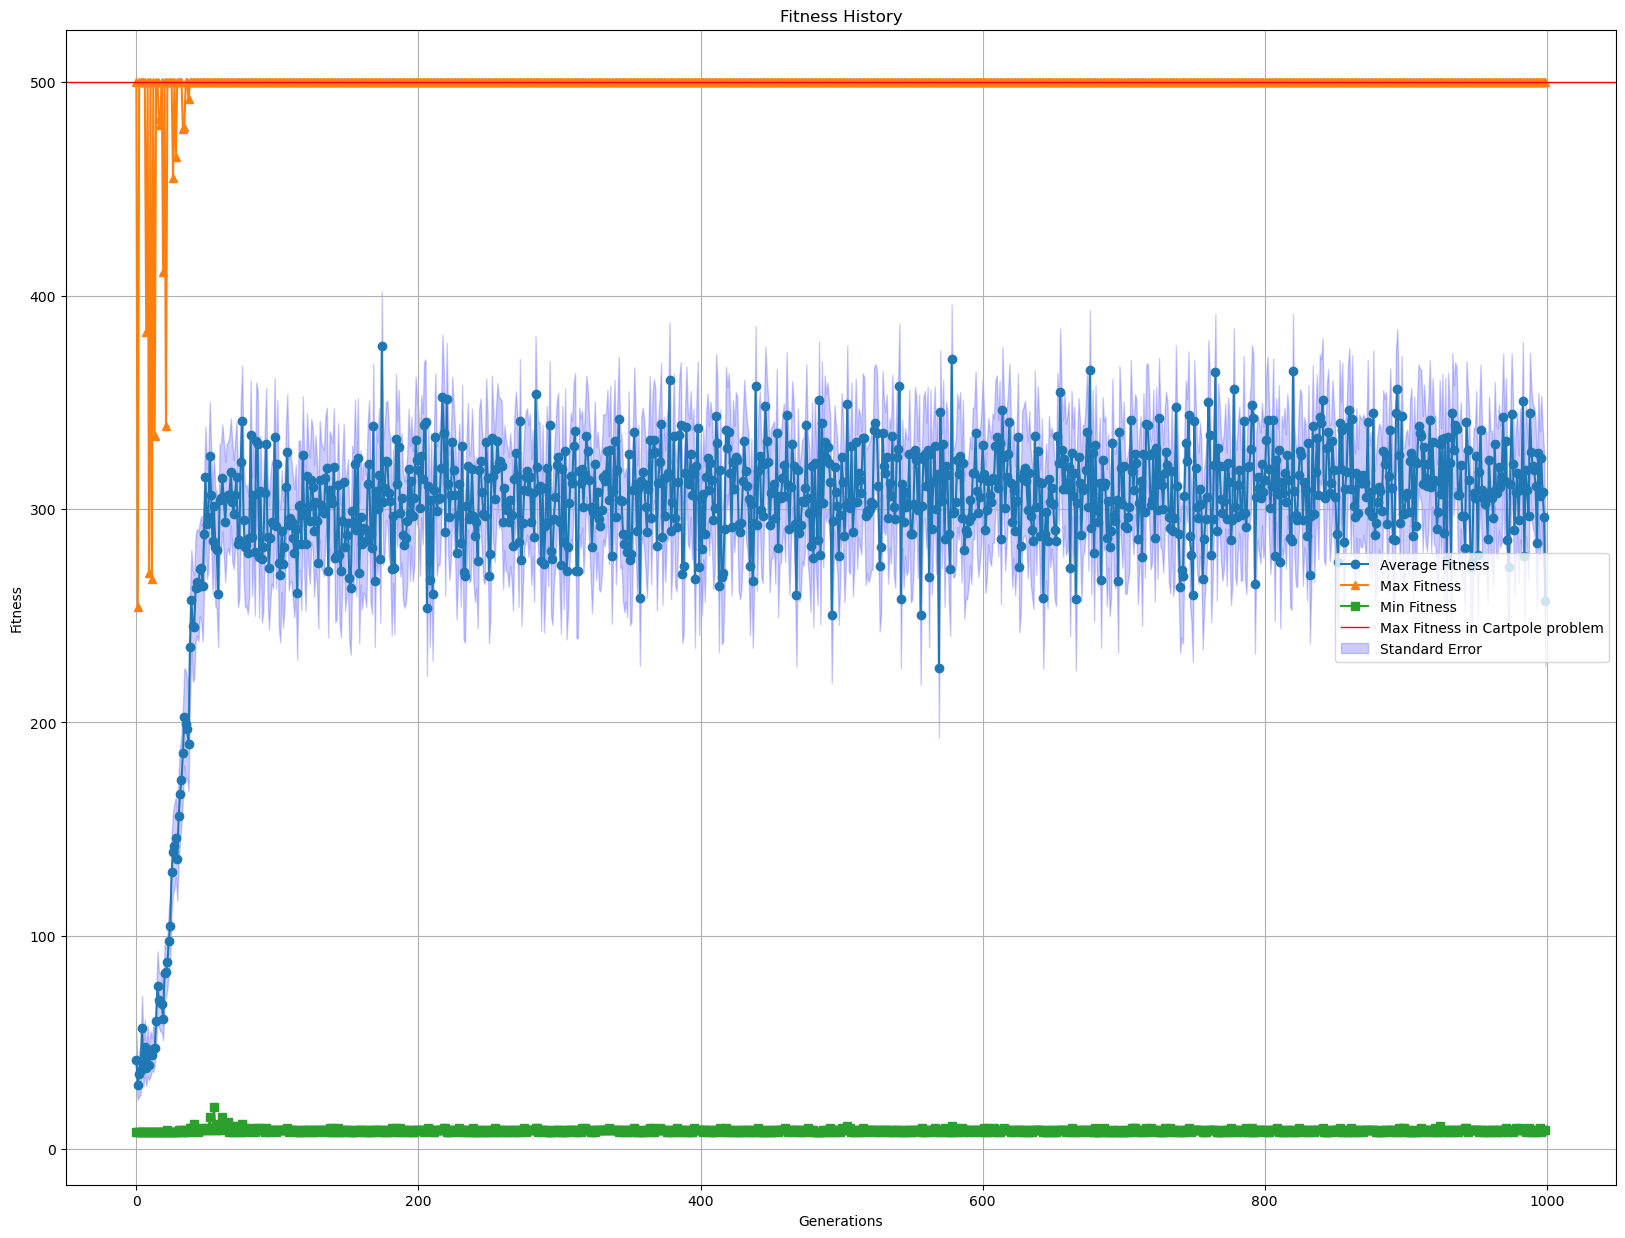

In [8]:
plt.figure(figsize=(20, 15))
plt.plot(np.arange(GENERATIONS), np.array(FITNESS_HISTORY)[:,0], marker='o', linestyle='-', label='Average Fitness')
plt.plot(np.arange(GENERATIONS), np.array(FITNESS_HISTORY)[:,1], marker='^', linestyle='-', label='Max Fitness')
plt.plot(np.arange(GENERATIONS), np.array(FITNESS_HISTORY)[:,2], marker='s', linestyle='-', label='Min Fitness')
plt.axhline(y=500, color='r', linewidth=1, label='Max Fitness in Cartpole problem')
plt.fill_between(np.arange(GENERATIONS), np.array(FITNESS_HISTORY)[:,0] - np.array(FITNESS_STDERROR_HISTORY), np.array(FITNESS_HISTORY)[:,0] + np.array(FITNESS_STDERROR_HISTORY),
                 alpha=0.2, color='blue', label='Standard Error')

plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.title('Fitness History')
plt.grid()
plt.legend()
plt.show()